In [1]:
#Import the libraries
import shutil
import tensorflow as tf
import pandas as pd
import numpy as np
from scipy import stats
import time
from datetime import datetime
import matplotlib.pyplot as plt
import os
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras import losses
from keras import regularizers
from keras import optimizers
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import LocalOutlierFactor
from sklearn.externals import joblib
from hyperopt import Trials, STATUS_OK, tpe
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from tqdm import tqdm
%matplotlib inline

Using TensorFlow backend.


In [2]:
#load the dataset used for this training session into ram
DS_path='D:/tf/4099_reduced_csa_ai/pcu_model/Results/DS_samples_0_10_transient.csv'

df=pd.read_csv(DS_path,index_col=["Time"])

mainPath="./models/test1/"

normalize_input = True
normalize_output = True

#shutil.rmtree(mainPath)
#os.makedirs(mainPath)

In [3]:
print(df.shape)
print("Total number of NAN entries:", df.isnull().sum().sum())
df.keys()

(341, 75)
Total number of NAN entries: 0


Index(['Board1Reduce', 'Board2Reduce', 'Board3Reduce', 'Board4Reduce',
       'Board5Reduce', 'Board6Reduce', 'Board7Reduce', 'Board8Reduce',
       'Board9Reduce', 'Board10Reduce', 'PanelReduce', 'Cover1Reduce',
       'Cover2Reduce', 'Cover3Reduce', 'Cover4Reduce', 'Cover5Reduce',
       'Board1R', 'Board2R', 'Board3R', 'Board4R', 'Board5R', 'Board6R',
       'Board7R', 'Board8R', 'Board9R', 'Board10R', 'PanelRe', 'Cover1R',
       'Cover2R', 'Cover3R', 'Cover4R', 'Cover5R', 'QNODE_Board1R',
       'QNODE_Board2R', 'QNODE_Board3R', 'QNODE_Board4R', 'QNODE_Board5R',
       'QNODE_Board6R', 'QNODE_Board7R', 'QNODE_Board8R', 'QNODE_Board9R',
       'QNODE_Board10', 'Board1R_Board2R', 'Board1R_PanelRe',
       'Board1R_Cover3R', 'Board2R_Board3R', 'Board2R_PanelRe',
       'Board3R_Board4R', 'Board3R_PanelRe', 'Board4R_Board5R',
       'Board4R_PanelRe', 'Board5R_Board6R', 'Board5R_PanelRe',
       'Board6R_Board7R', 'Board6R_PanelRe', 'Board7R_Board8R',
       'Board7R_PanelRe', 'Board8

In [4]:
#df = df.drop(df.index[31:81]) #!!!!!!!!!!!!!!!!!

In [5]:
input_list=['Board1R', 'Board2R', 'Board3R', 'Board4R', 'Board5R', 'Board6R',
            'Board7R', 'Board8R', 'Board9R', 'Board10R', 'PanelRe', 'Cover1R',
            'Cover2R', 'Cover3R', 'Cover4R', 'Cover5R', 'QNODE_Board1R',
            'QNODE_Board2R', 'QNODE_Board3R', 'QNODE_Board4R', 'QNODE_Board5R',
            'QNODE_Board6R', 'QNODE_Board7R', 'QNODE_Board8R', 'QNODE_Board9R',
            'QNODE_Board10']
            
output_list=['Board1R_Board2R', 'Board1R_PanelRe',
             'Board1R_Cover3R', 'Board2R_Board3R', 'Board2R_PanelRe',
             'Board3R_Board4R', 'Board3R_PanelRe', 'Board4R_Board5R',
             'Board4R_PanelRe', 'Board5R_Board6R', 'Board5R_PanelRe',
             'Board6R_Board7R', 'Board6R_PanelRe', 'Board7R_Board8R',
             'Board7R_PanelRe', 'Board8R_Board9R', 'Board8R_PanelRe',
             'Board9R_Board10', 'Board9R_PanelRe', 'Board10_PanelRe',
             'Board10_Cover1R', 'PanelRe_Cover1R', 'PanelRe_Cover2R',
             'PanelRe_Cover3R', 'PanelRe_Cover4R', 'Cover1R_Cover2R',
             'Cover1R_Cover4R', 'Cover1R_Cover5R', 'Cover2R_Cover3R',
             'Cover2R_Cover5R', 'Cover3R_Cover4R', 'Cover3R_Cover5R',
             'Cover4R_Cover5R']

temp_list=['Board1R', 'Board2R', 'Board3R', 'Board4R', 'Board5R', 'Board6R',
           'Board7R', 'Board8R', 'Board9R', 'Board10R', 'PanelRe', 'Cover1R',
           'Cover2R', 'Cover3R', 'Cover4R', 'Cover5R']

fullTemp_list=['Board1Reduce', 'Board2Reduce', 'Board3Reduce', 'Board4Reduce',
               'Board5Reduce', 'Board6Reduce', 'Board7Reduce', 'Board8Reduce',
               'Board9Reduce', 'Board10Reduce', 'PanelReduce', 'Cover1Reduce',
               'Cover2Reduce', 'Cover3Reduce', 'Cover4Reduce', 'Cover5Reduce']

In [6]:
#The temperatures from current time step and heat loads from next times step should be used to
#calculate the next time step conductances. Therefore, We shift the first time step temperatures one row down, 
#then delete the first time step rows.
num_snapshot=df.index.value_counts()[0]
df[temp_list]=df[temp_list].shift(1)
len_snapshot=int(len(df)/num_snapshot)

drop_list=[]
for i in range(num_snapshot):
    drop_list.append(i*len_snapshot)

df=df.drop(df.index[drop_list])
print(df.shape)

(330, 75)


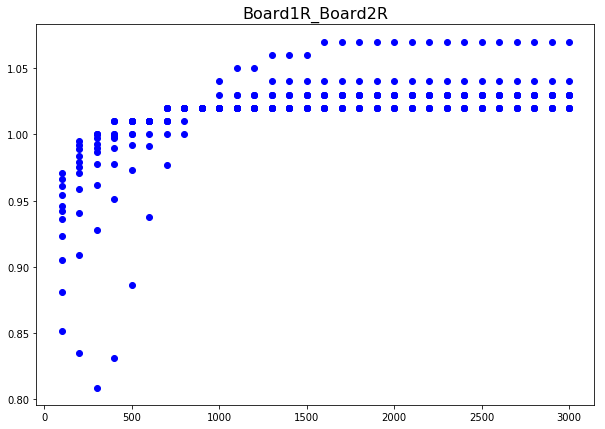

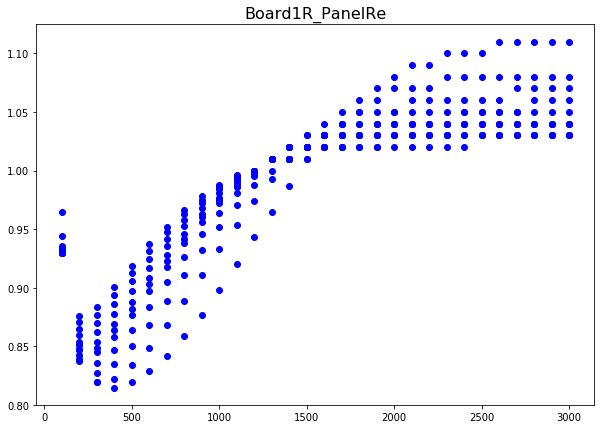

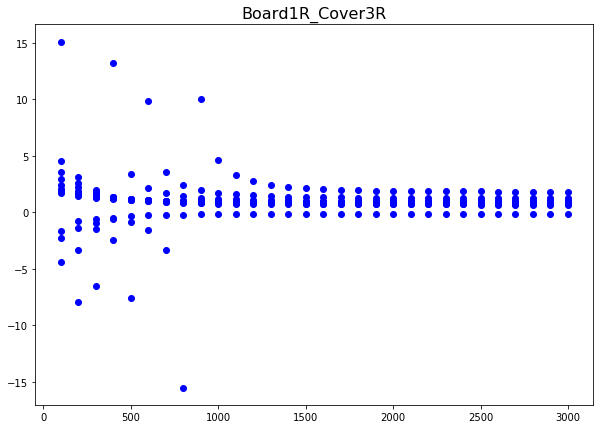

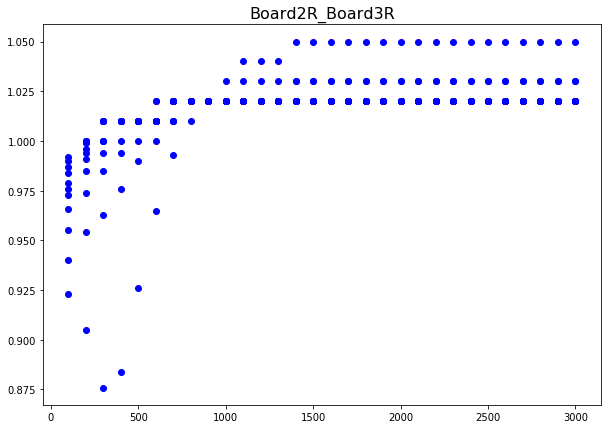

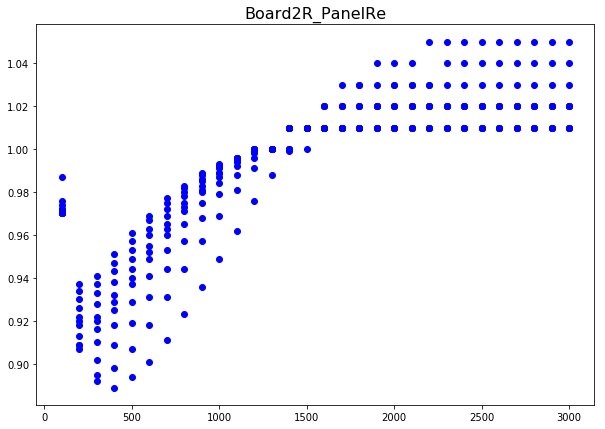

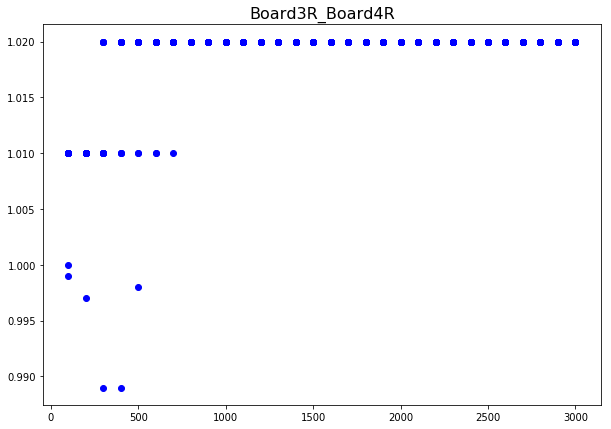

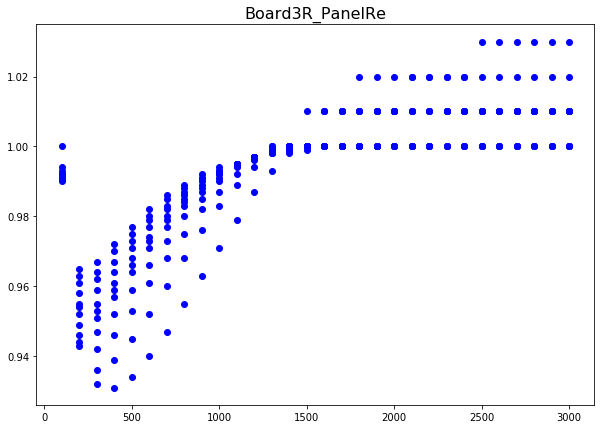

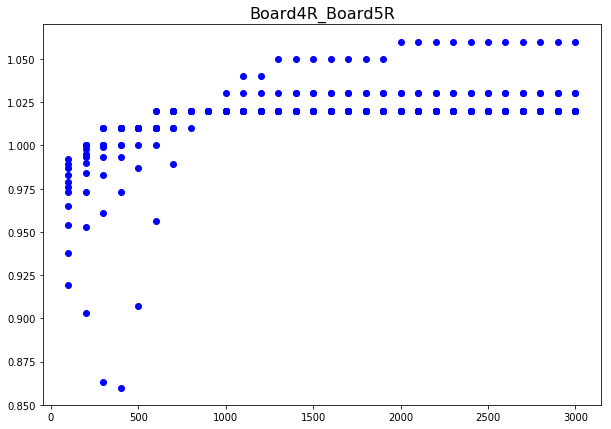

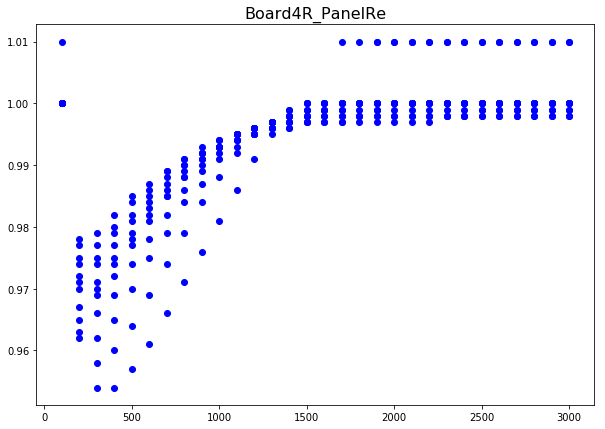

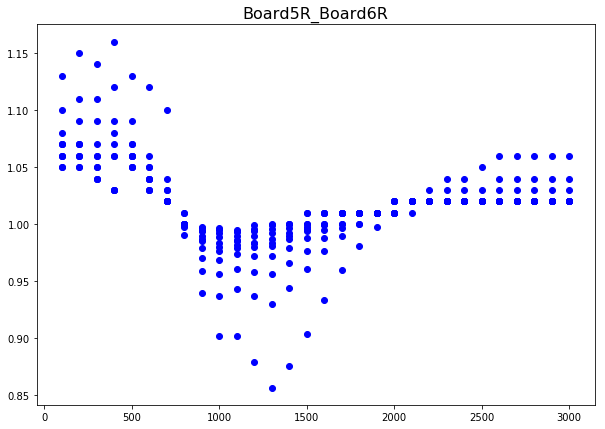

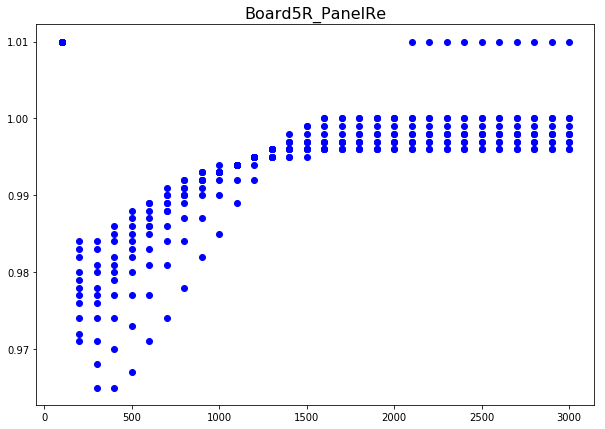

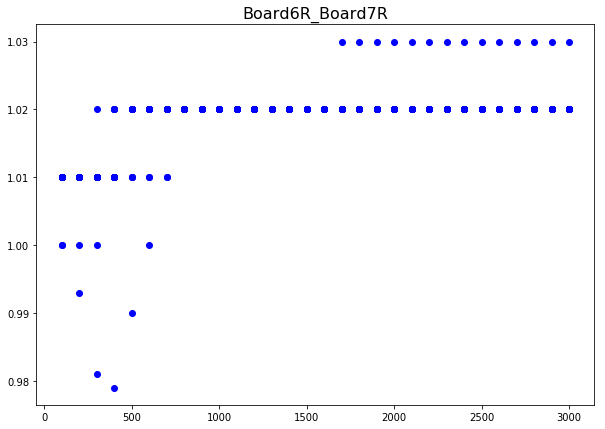

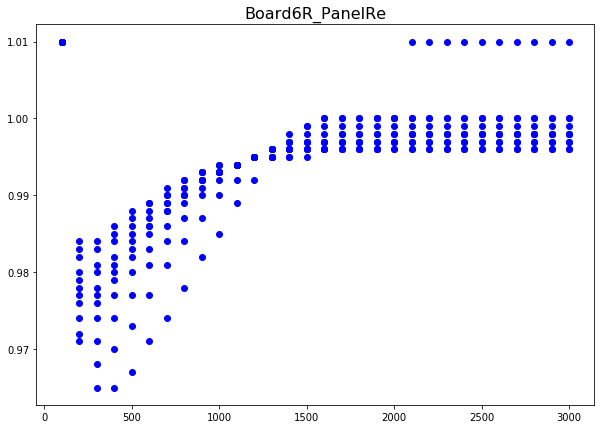

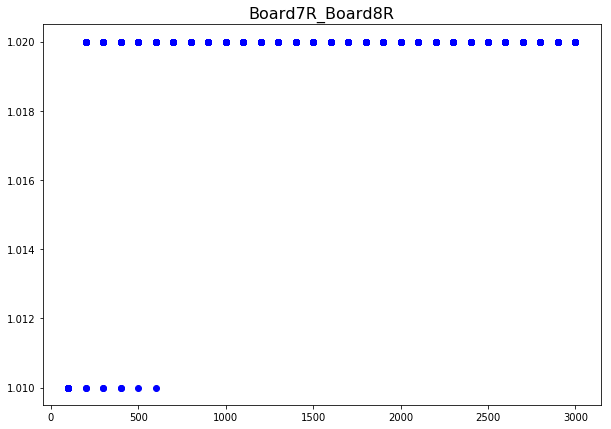

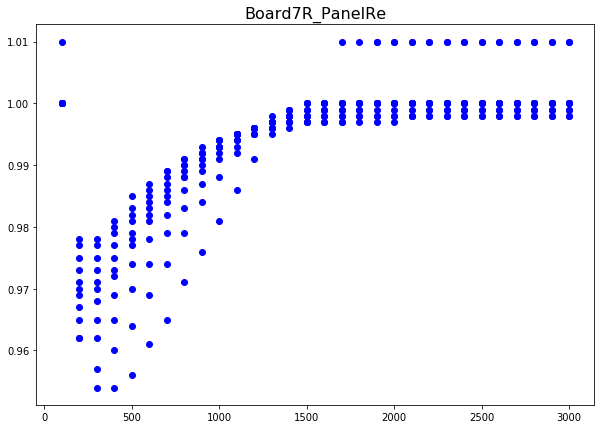

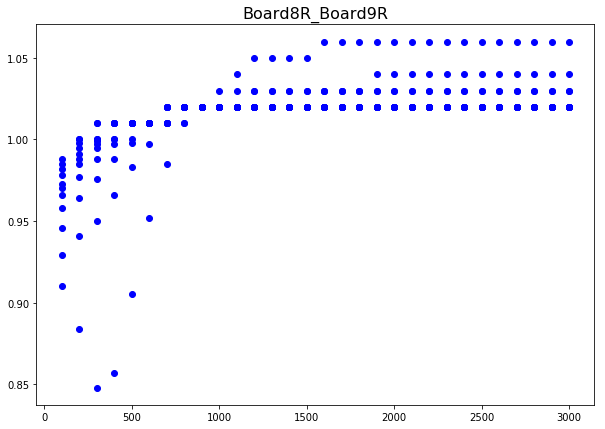

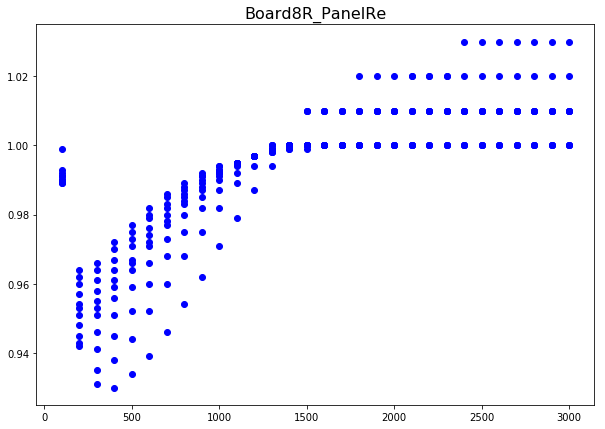

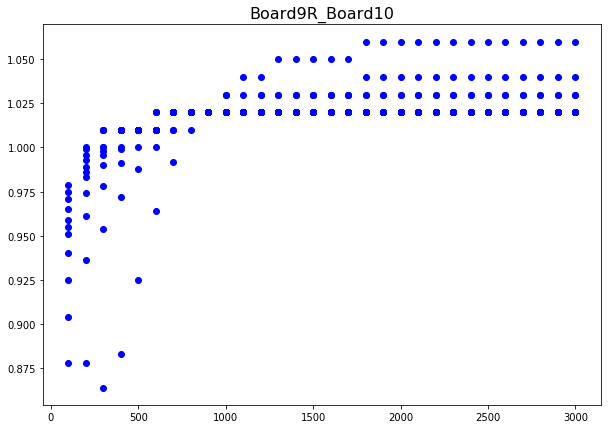

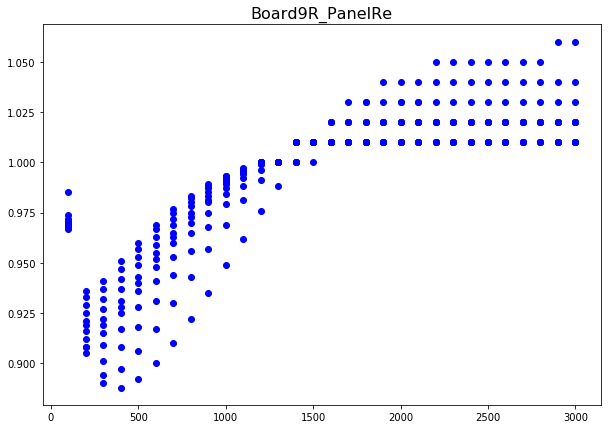

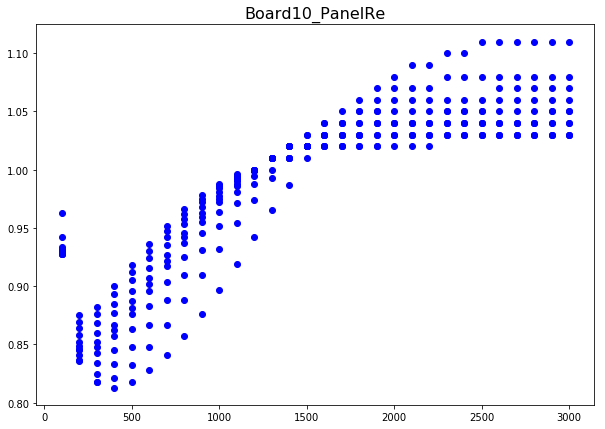

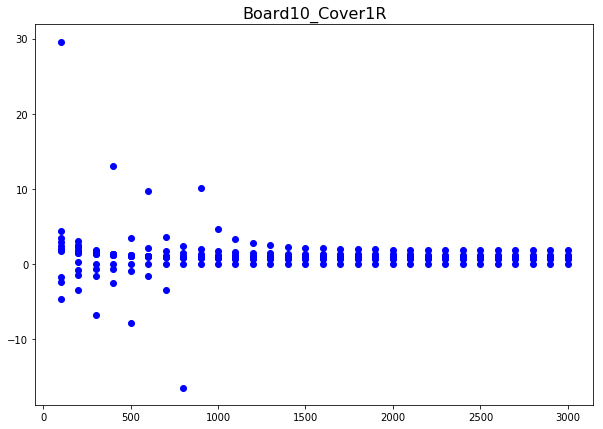

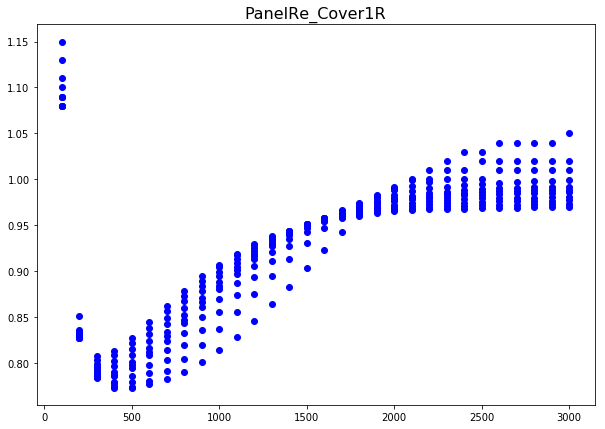

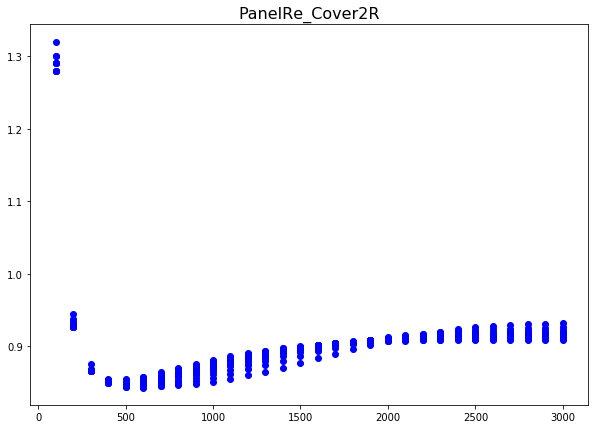

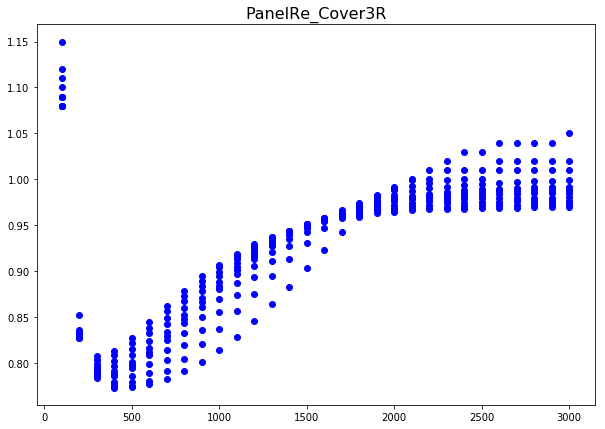

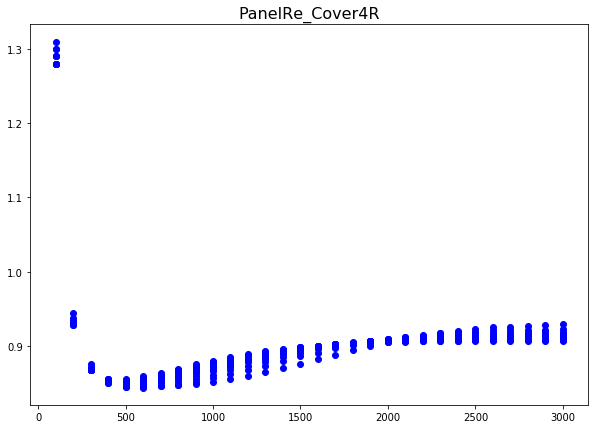

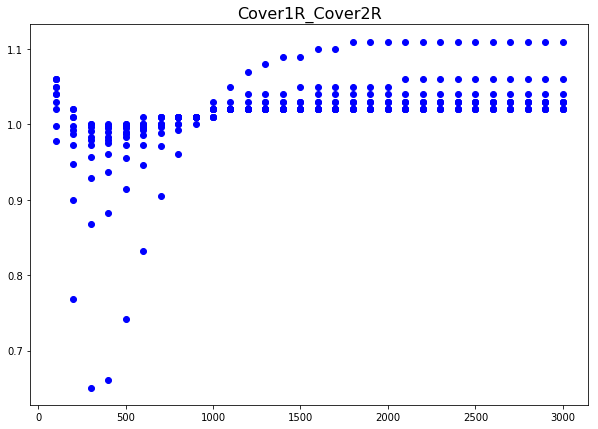

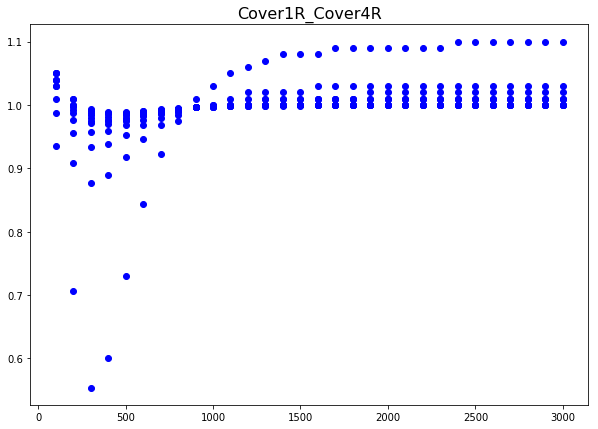

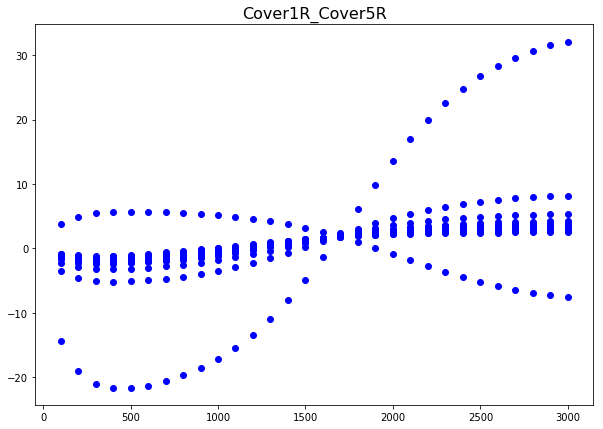

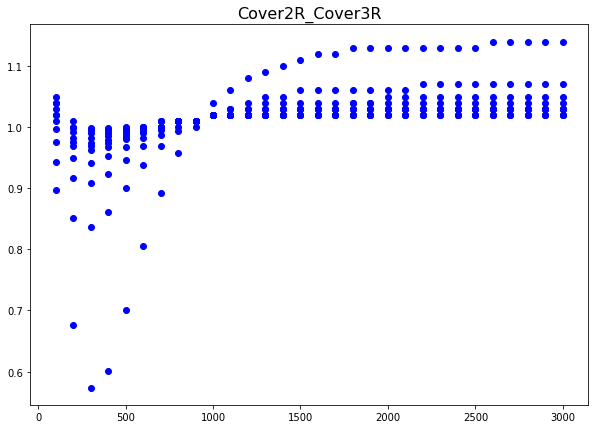

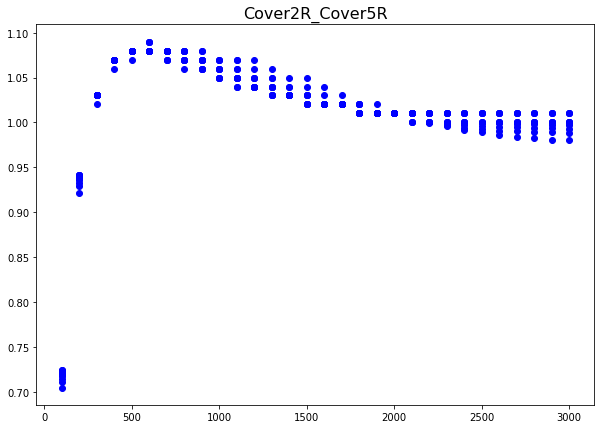

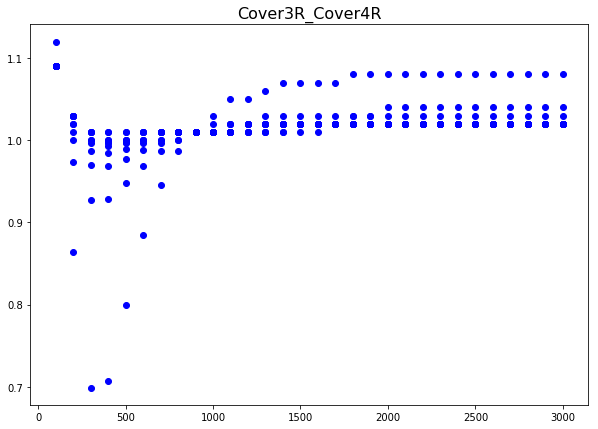

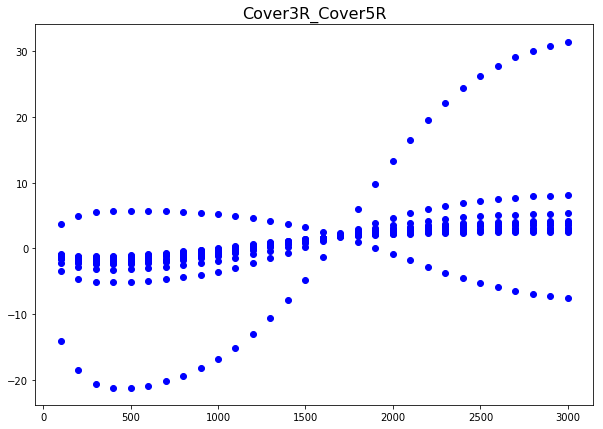

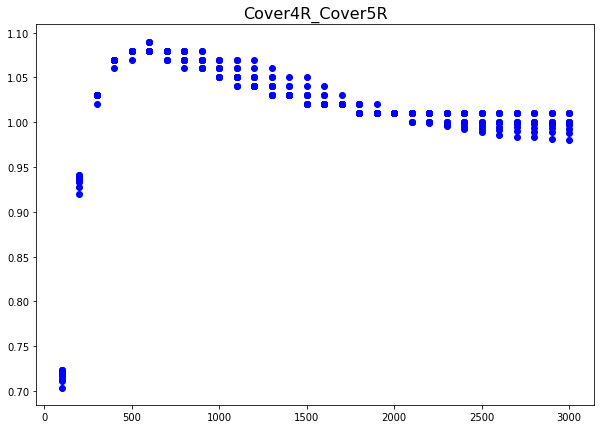

In [7]:
for output in output_list:
    fig,ax=plt.subplots(figsize=(10,7))
    ax.plot(df[output], 'bo')
    ax.set_title(output, fontsize=16)
    plt.show()

In [8]:
#Define a new dataset with only input features
x_data=df[input_list]

#Remove the multi-index layer (time) before training
x_data=x_data.reset_index(drop=True)

In [9]:
#Create dataframe with only conductance features (your y training set)
y_data=df[output_list]

#Remove the multi-index layer (time) before training
y_data=y_data.reset_index(drop=True)

In [10]:
#Scale the input tarining data
if normalize_input:
    x_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(x_data)
    joblib.dump(x_scaler, mainPath+'input_scaling.pkl')
    x_temp = x_scaler.transform(x_data)
else:
    x_temp = x_data.values

#Scale the output training data
if normalize_output:
    y_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(y_data)
    joblib.dump(y_scaler, mainPath+'output_scaling.pkl')
    y_temp = y_scaler.transform(y_data)
else:
    y_temp = y_data.values

#Create a train/test split
x_train, x_test, y_train_all, y_test_all = train_test_split(x_temp, y_temp, test_size=0.05)

print(x_train.shape, x_test.shape)
print(y_train_all.shape, y_test_all.shape)

(313, 26) (17, 26)
(313, 33) (17, 33)


In [11]:
#Loading validation data
#DS_path = './datasets/DS_samples_1_steady.csv'
DS_path='D:/tf/4099_reduced_csa_ai/pcu_model/Results/DS_samples_0_transient.csv'
df2 = pd.read_csv(DS_path,index_col=["Time"])

#Shift the data to use temperatures from previous time step
num_snapshot2 = df2.index.value_counts()[0]
df2[temp_list] = df2[temp_list].shift(1)
len_snapshot2 = int(len(df2)/num_snapshot2)

drop_list2 = []
for i in range(num_snapshot2):
    drop_list2.append(i*len_snapshot2)

df2 = df2.drop(df2.index[drop_list2])
df2 = df2.reset_index(drop=True)

#Create validation input and output datasets
x_validation = df2[input_list].values
y_validation_all = df2[output_list].values

#Scaling the input validation data
if normalize_input:
    x_validation = x_scaler.transform(x_validation)

if normalize_output:
    y_validation_all = y_scaler.transform(y_validation_all)

print(x_validation.shape, y_validation_all.shape)

(30, 26) (30, 33)


In [12]:
import seaborn as sns
debug = False

if debug:

    for i in range(len(output_list)):
        out_var = [output_list[i]]
        df_test=df[out_var + input_list]

        #correlation matrix
        corrmat = df_test.corr()

        print(corrmat.abs().nlargest(len(input_list)+1, out_var)[out_var])

        f, ax = plt.subplots(figsize=(12, 9))
        sns.heatmap(corrmat, vmax=.8, square=True);
        plt.show()

        #Top k correlated features to the out_var
        k = 7
        cols = corrmat.abs().nlargest(k, out_var)[out_var].index
        cm = np.corrcoef(df_test[cols].values.T)
        f, ax = plt.subplots(figsize=(12, 9))
        sns.set(font_scale=1.25)
        hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
        plt.show()

# Rule of thumb for the number of hidden layers:
Nh = Ns/(alpha * (Ni + No)) =~ 12 * number_of_snapshots / alpha

where

Ni = number of input neurons = 20

No = number of output neurons = 1

Ns = number of samples in training data set = 241 * number of snapshots

alpha = an arbitrary scaling factor usually 2-10 (lower value avoids overfitting)

# Number of neurons in hidden layers:
The optimal number of neurons is usually between the size of the input (20) and size of the output (1) layers

In [13]:
#Attention: epsilon is added to avoid division by zero
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1.0e-8
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

In [14]:
def create_model(params):
    
    global eval_count
    eval_count = eval_count + 1
    print('Parameter optimization evalation round:', eval_count)
    print('Params testing: ', params)
    
    model = Sequential()
    
    model.add(Dense(units=int(params['units1']), input_dim = len(x_train[0,:])))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(params['dropout']))

    model.add(Dense(units=int(params['units2'])))
    model.add(Activation('relu'))
    model.add(Dropout(params['dropout']))
    
    model.add(Dense(units=int(params['units3'])))
    model.add(Activation('relu'))
    model.add(Dropout(params['dropout']))
    
    model.add(Dense(units=int(params['units4'])))
    model.add(Activation('relu'))
    model.add(Dropout(params['dropout']))
    
    if params['num_layers'] != 'four':
        for i in range(2):
            model.add(Dense(units=int(params['units6'])))
            model.add(Activation('relu'))
            model.add(Dropout(params['dropout']))
        
    if params['num_layers'] in ['eight', 'ten']:
        for i in range(2):
            model.add(Dense(units=int(params['units8'])))
            model.add(Activation('relu'))
            model.add(Dropout(params['dropout']))

    if params['num_layers'] == 'ten':
        for i in range(2):
            model.add(Dense(units=int(params['units10'])))
            model.add(Activation('relu'))
            model.add(Dropout(params['dropout']))

    model.add(Dense(1))
    
    loss = 'mean_absolute_error'
    #loss = 'mean_squared_error'
    #loss = 'logcosh'
    #loss = 'mean_absolute_percentage_error'
    
    learning_rate = params['learning_rate']
    optimizer = optimizers.Adam(lr=learning_rate)
    model.compile(loss=loss, optimizer=optimizer, metrics=['mse', 'mae', 'mape'])
    
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=nb_epochs/4, verbose=0)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=nb_epochs/4, min_lr=0.0625*learning_rate)
    callbacks = [early_stop, reduce_lr]
    
    result = model.fit(x_train, y_train, epochs=nb_epochs, verbose=0, 
                       batch_size=int(params['batch_size']), callbacks = callbacks,
                       validation_data = (x_test, y_test))

    predicted = model.predict(x_test)
    #error = mean_absolute_error(y_test, predicted)
    error = mean_absolute_percentage_error(y_test, predicted)
    print('Error:', error,"\n")
    
    global least_error
    if (error < least_error):
        least_error = error
        
        #Serialize model to JSON
        model_json = model.to_json()
        with open(mainPath+"model"+output_list[output_col]+".json", "w") as json_file:
            json_file.write(model_json)

        #Serialize weights to HDF5
        model.save_weights(mainPath+"model"+output_list[output_col]+".h5")
    
    return {'loss': error, 'status': STATUS_OK}

  0%|                                                                                           | 0/33 [00:00<?, ?it/s]


 ******************************************************************************** 
 Processing output Board1R_Board2R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'ten', 'units10': 29.777160990649847, 'batch_size': 32, 'units8': 20.58834131471275, 'learning_rate': 0.007775485343258071, 'units4': 26.896547118079205, 'dropout': 0.004565061621853084, 'units1': 25.421816804395302, 'units2': 46.08267766314043, 'units6': 62.39021541464942, 'units3': 42.42225820792882}
Error: 6.039555172644831 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'six', 'units10': 26.176225018943484, 'batch_size': 64, 'units8': 37.04820423939068, 'learning_rate': 0.0029282182181271394, 'units4': 34.560986750033734, 'dropout': 0.0581675615099208, 'units1': 33.92968166833205, 'units2': 54.5069223121783, 'units6': 61.103193896113325, 'units3': 29.231798287912177}
Error: 7.079016547668415 

Parameter optimization evalation round: 3
Params testing:  {'num_layers'

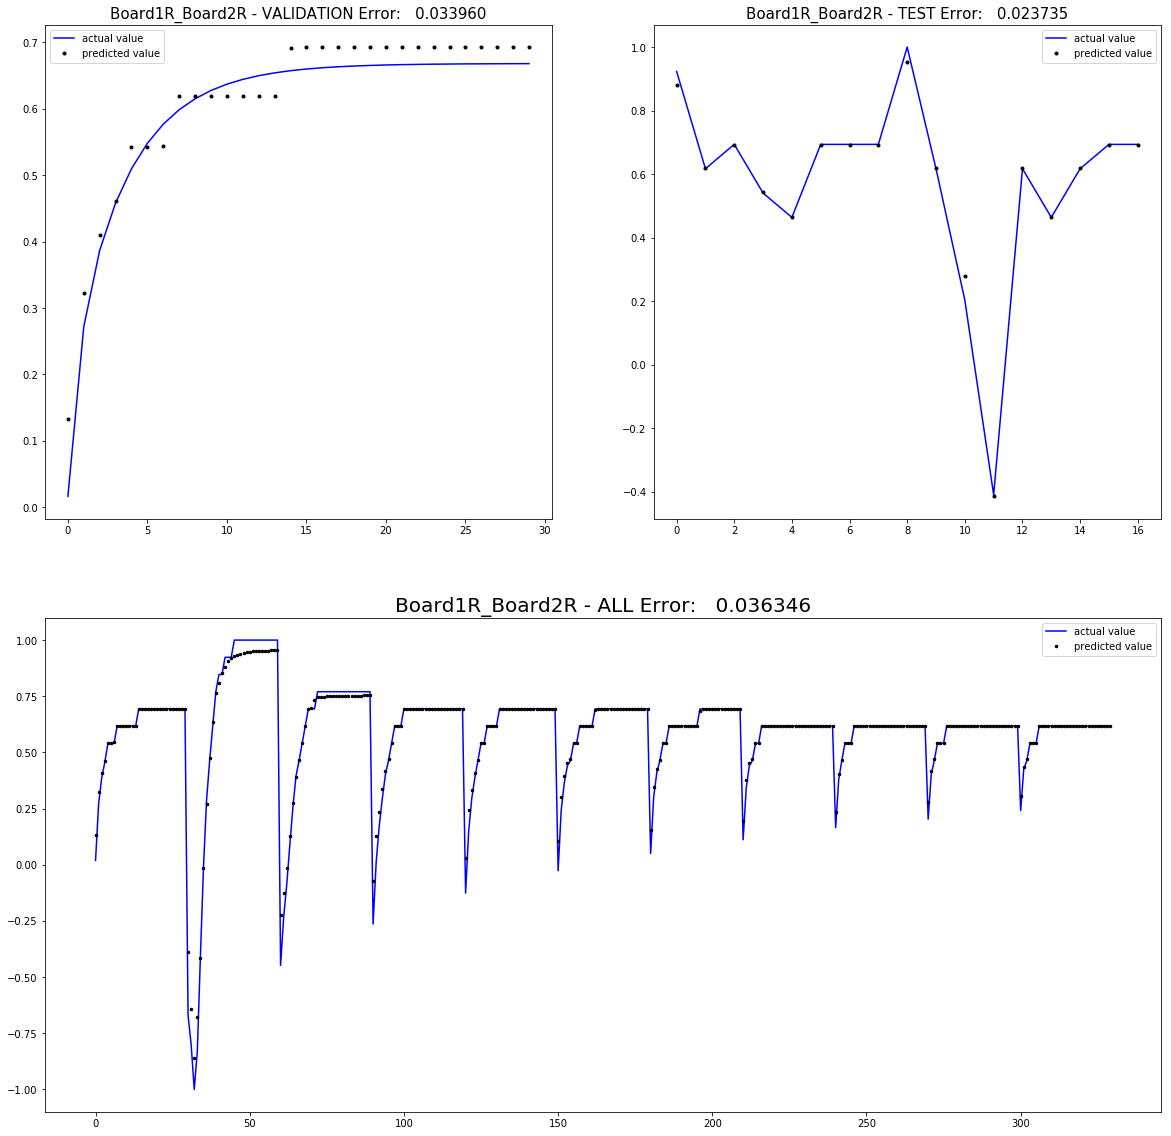

  3%|██▍                                                                             | 1/33 [02:16<1:12:45, 136.42s/it]


 ******************************************************************************** 
 Processing output Board1R_PanelRe
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'eight', 'units10': 62.42886961649111, 'batch_size': 64, 'units8': 59.274766082088405, 'learning_rate': 0.007529054323834091, 'units4': 28.490588043180743, 'dropout': 0.02412343261728336, 'units1': 63.88392544678548, 'units2': 48.01356243159647, 'units6': 35.3808098596898, 'units3': 47.987549147744645}
Error: 20.82907450413156 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'four', 'units10': 18.858837490649243, 'batch_size': 64, 'units8': 56.117288510835394, 'learning_rate': 0.00486989004970082, 'units4': 38.99427233332161, 'dropout': 0.08287149516537741, 'units1': 30.93877503953254, 'units2': 63.8883517712042, 'units6': 63.53546137986925, 'units3': 35.51457451912857}
Error: 92.24739979925714 

Parameter optimization evalation round: 3
Params testing:  {'num_layers': 

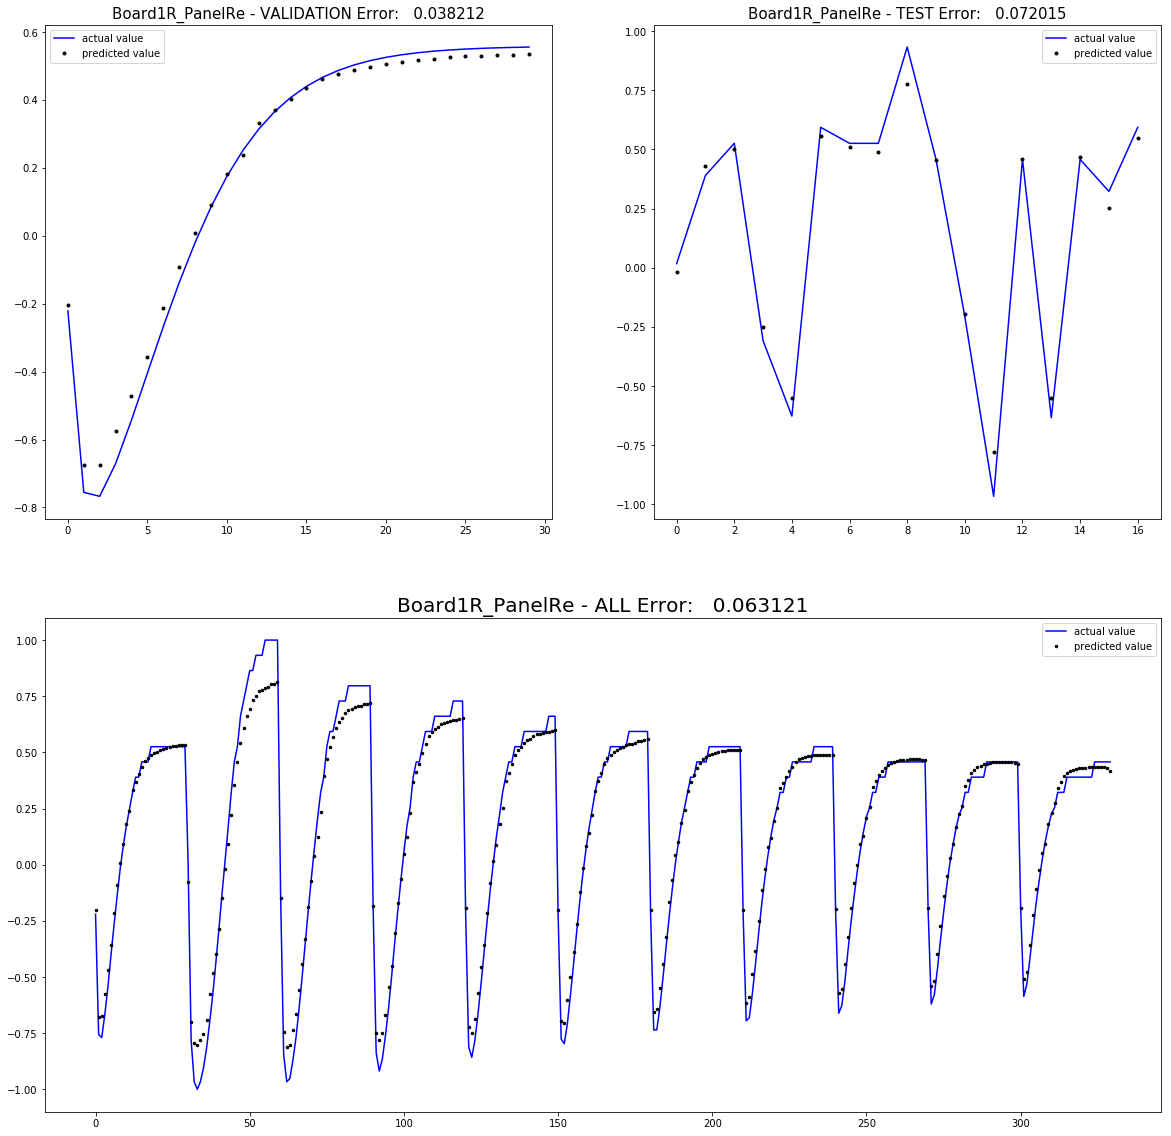

  6%|████▊                                                                           | 2/33 [04:21<1:07:40, 130.99s/it]


 ******************************************************************************** 
 Processing output Board1R_Cover3R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'ten', 'units10': 61.99080286563442, 'batch_size': 32, 'units8': 58.11758682774197, 'learning_rate': 0.003726895565209423, 'units4': 48.21808559170735, 'dropout': 0.02963049346997563, 'units1': 25.271094105973944, 'units2': 51.12999064802893, 'units6': 20.076646674101642, 'units3': 27.728956296295472}
Error: 34.55628546366501 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'four', 'units10': 53.96756221450755, 'batch_size': 64, 'units8': 24.865774319541224, 'learning_rate': 0.005158350922997439, 'units4': 60.81732262267707, 'dropout': 0.07718961730843817, 'units1': 30.531145366234355, 'units2': 23.372154945229674, 'units6': 41.70079330700832, 'units3': 24.233705452168294}
Error: 51.864570962134415 

Parameter optimization evalation round: 3
Params testing:  {'num_layer

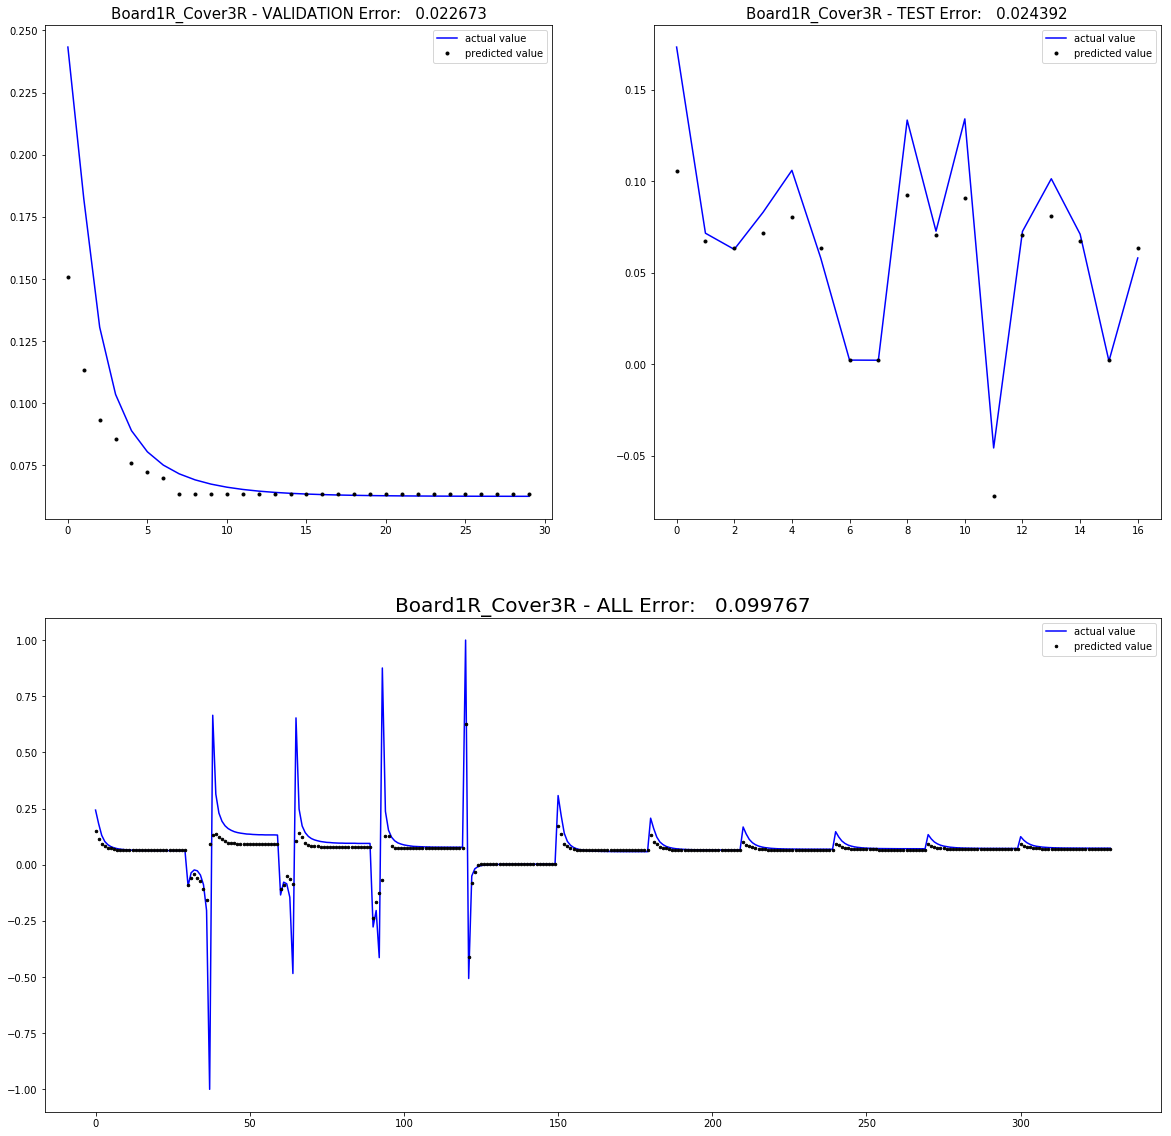

  9%|███████▍                                                                          | 3/33 [05:47<57:51, 115.73s/it]


 ******************************************************************************** 
 Processing output Board2R_Board3R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'four', 'units10': 29.037430040492673, 'batch_size': 32, 'units8': 60.95677810115727, 'learning_rate': 0.0054971235557932305, 'units4': 41.87351137702737, 'dropout': 0.0662864489006682, 'units1': 53.67781153232161, 'units2': 34.66861827292021, 'units6': 44.45956553549463, 'units3': 58.85599849443561}
Error: 2.3632398467549494 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'four', 'units10': 32.78774035118167, 'batch_size': 64, 'units8': 40.33463533647334, 'learning_rate': 0.009402104082675018, 'units4': 17.72154384802071, 'dropout': 0.05415050872833134, 'units1': 32.69075588730537, 'units2': 63.68996123651081, 'units6': 19.782558416694247, 'units3': 50.36568939218647}
Error: 7.362128922730185 

Parameter optimization evalation round: 3
Params testing:  {'num_layers': 

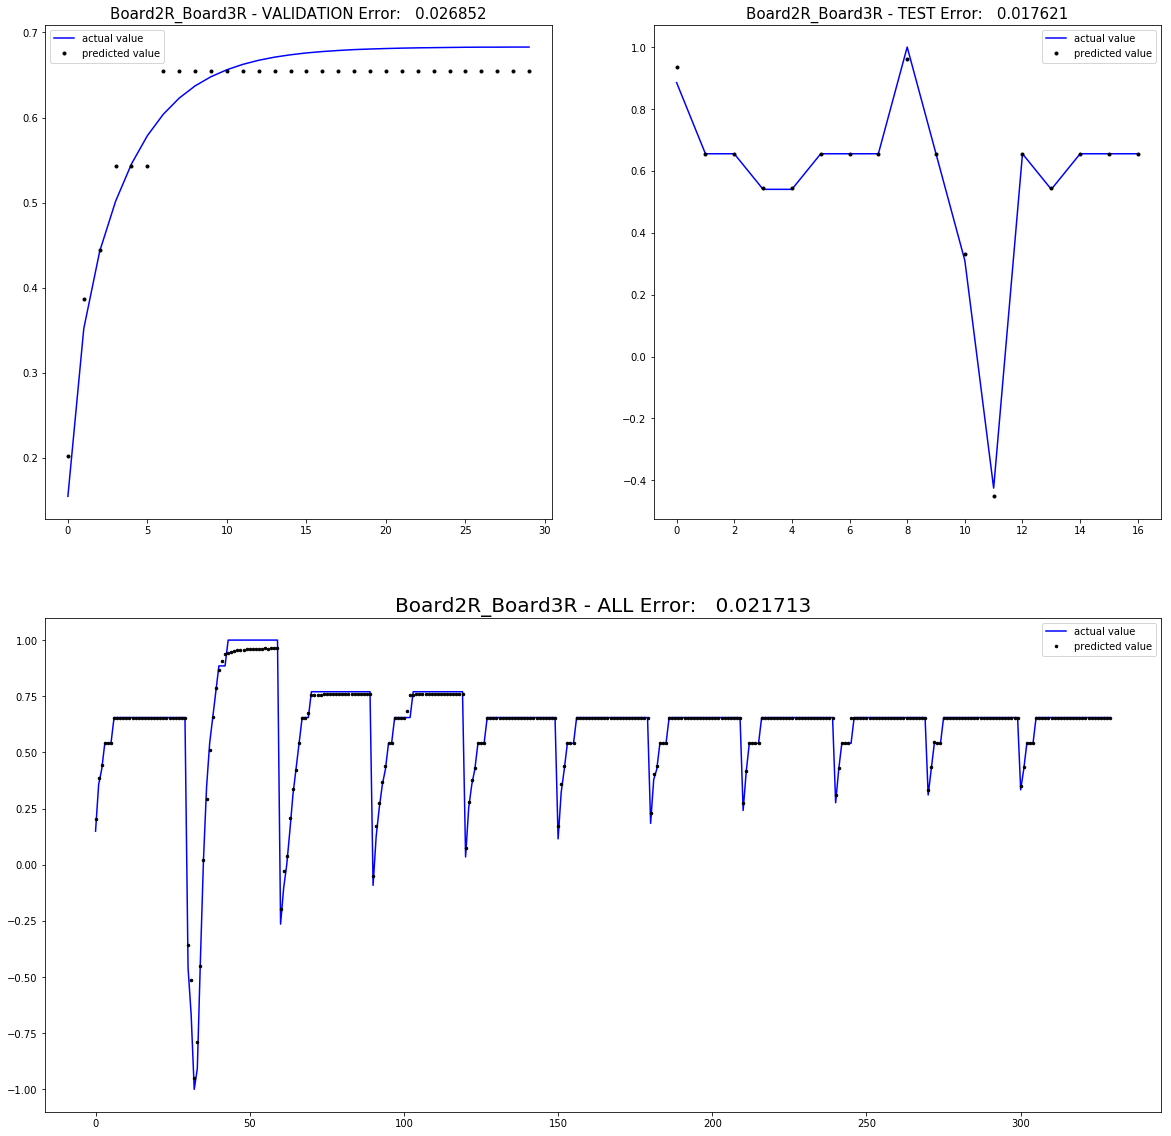

 12%|█████████▉                                                                        | 4/33 [07:22<53:25, 110.55s/it]


 ******************************************************************************** 
 Processing output Board2R_PanelRe
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'six', 'units10': 33.382378582811455, 'batch_size': 64, 'units8': 23.50144928262418, 'learning_rate': 0.007082177638507338, 'units4': 18.260555867083156, 'dropout': 0.035126843421425046, 'units1': 16.512508192978608, 'units2': 45.335283553373806, 'units6': 18.092929190246505, 'units3': 50.79969806086976}
Error: 23.03290877860471 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'eight', 'units10': 44.23106878191745, 'batch_size': 32, 'units8': 60.399016696723635, 'learning_rate': 0.009973272114787015, 'units4': 41.53027879693455, 'dropout': 0.03962806187678752, 'units1': 62.9846493189329, 'units2': 56.64931579259821, 'units6': 60.14582039415832, 'units3': 30.691782161538583}
Error: 16.76939983555057 

Parameter optimization evalation round: 3
Params testing:  {'num_layer

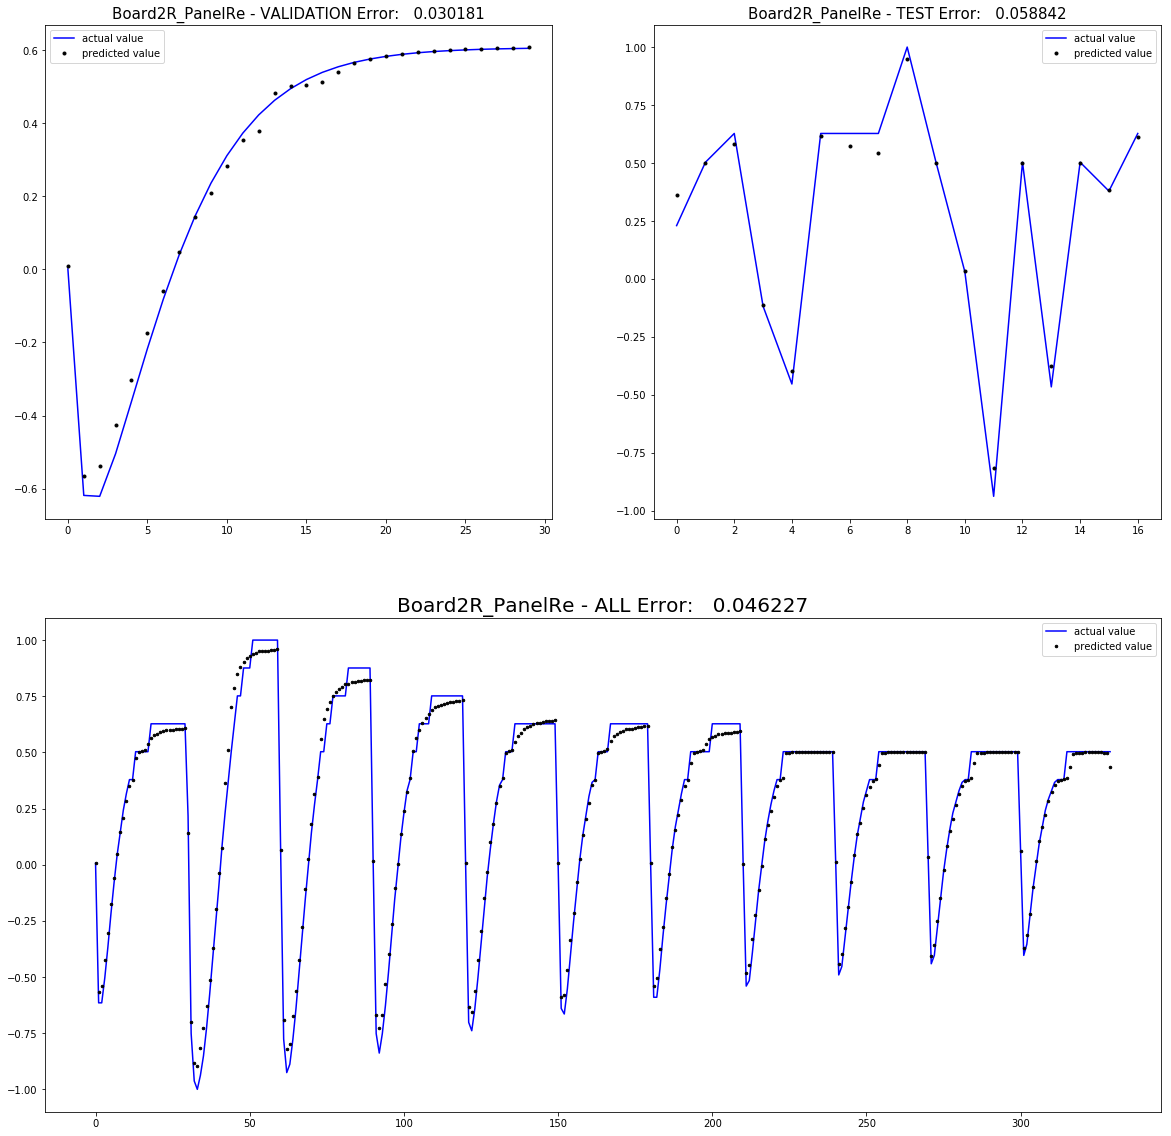

 15%|████████████▍                                                                     | 5/33 [09:33<53:29, 114.63s/it]


 ******************************************************************************** 
 Processing output Board3R_Board4R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'eight', 'units10': 48.649870993723326, 'batch_size': 32, 'units8': 52.372122860786135, 'learning_rate': 0.007115749577635627, 'units4': 23.193335579385668, 'dropout': 0.03467244948323787, 'units1': 24.81458311863861, 'units2': 43.44434612696301, 'units6': 54.09766255750963, 'units3': 19.55560305539761}
Error: 23.963166385330084 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'six', 'units10': 59.18239040781499, 'batch_size': 32, 'units8': 20.699675747774933, 'learning_rate': 0.0011546549977842775, 'units4': 43.51455934959348, 'dropout': 0.06901401834079539, 'units1': 62.19687059326102, 'units2': 33.57649524840334, 'units6': 22.705631095633734, 'units3': 21.750937898633705}
Error: 12.158371352268931 

Parameter optimization evalation round: 3
Params testing:  {'num_lay

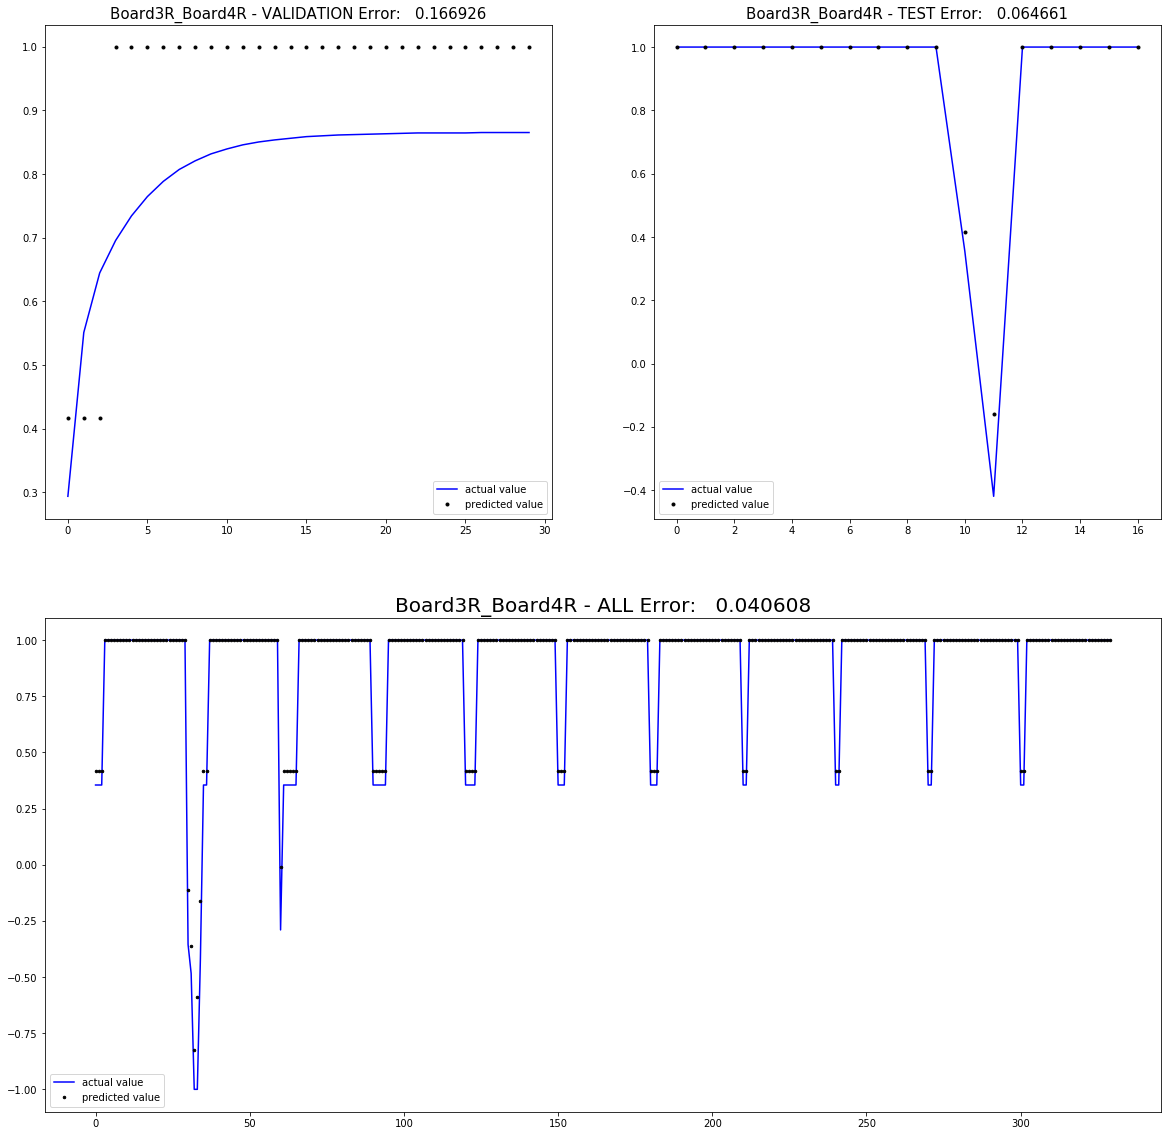

 18%|██████████████▉                                                                   | 6/33 [11:41<52:37, 116.93s/it]


 ******************************************************************************** 
 Processing output Board3R_PanelRe
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'eight', 'units10': 62.30229572935484, 'batch_size': 32, 'units8': 30.40448654532954, 'learning_rate': 0.006359217051051751, 'units4': 29.471262747244687, 'dropout': 0.021823249411534785, 'units1': 51.28216129682693, 'units2': 44.67884517252983, 'units6': 53.287342430796414, 'units3': 23.69812815078225}
Error: 10.564204971698528 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'six', 'units10': 46.486612853602395, 'batch_size': 32, 'units8': 24.8431765894018, 'learning_rate': 0.0023985796565813623, 'units4': 39.56711665652172, 'dropout': 0.07989489102192544, 'units1': 47.62018880249294, 'units2': 30.592564984421212, 'units6': 25.57422886923031, 'units3': 41.67709547618257}
Error: 26.918293450161677 

Parameter optimization evalation round: 3
Params testing:  {'num_layer

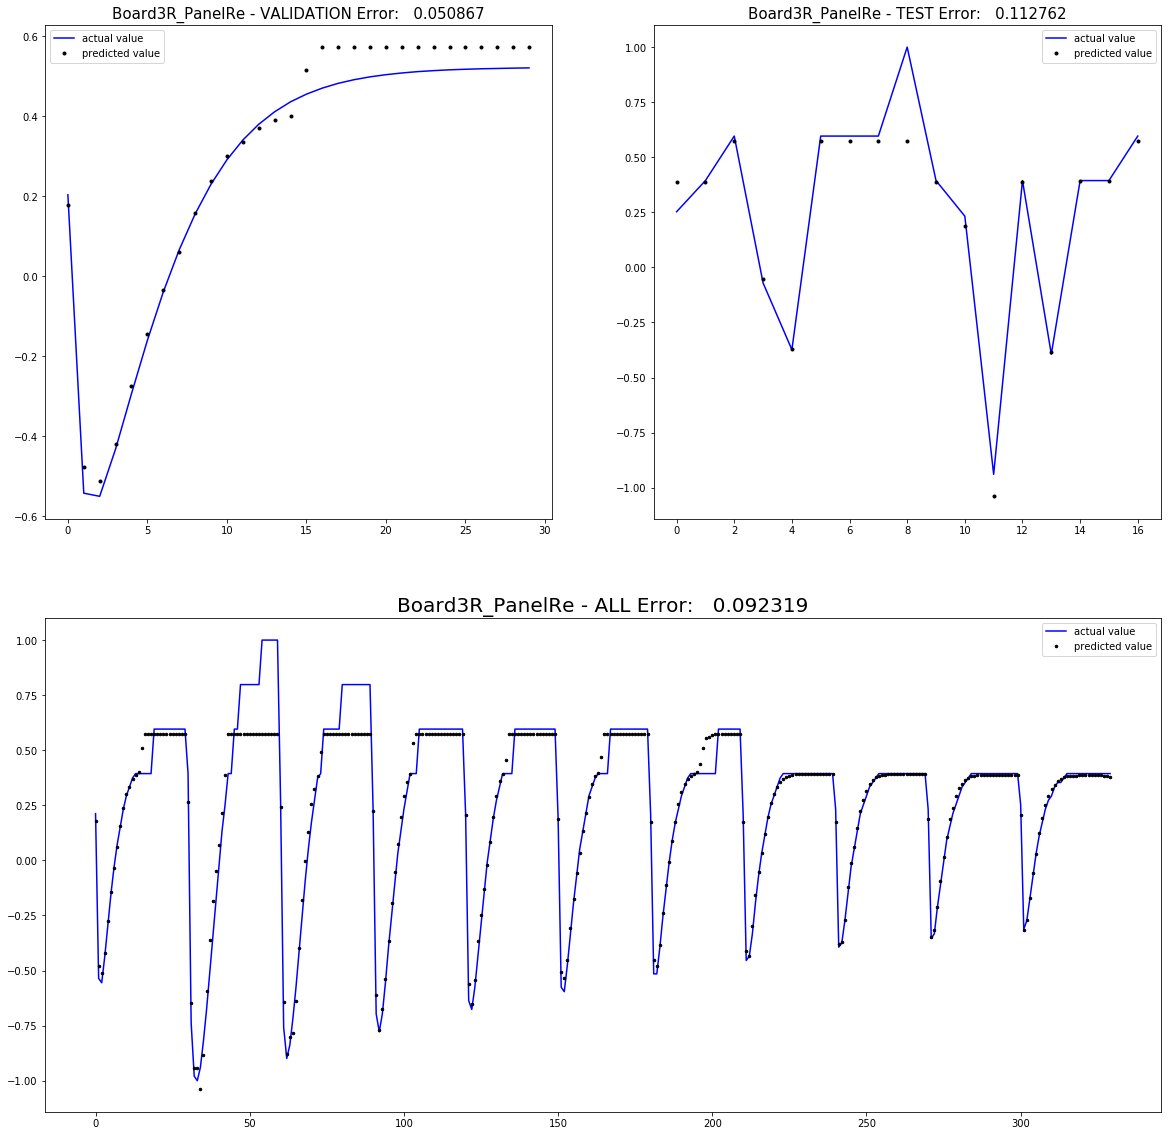

 21%|█████████████████▍                                                                | 7/33 [15:23<57:10, 131.94s/it]


 ******************************************************************************** 
 Processing output Board4R_Board5R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'eight', 'units10': 62.03624996039339, 'batch_size': 64, 'units8': 39.97769249948974, 'learning_rate': 0.003874412707510785, 'units4': 36.96878346164856, 'dropout': 0.0035642767424628463, 'units1': 51.108340138936526, 'units2': 28.771602014671675, 'units6': 23.42424517902146, 'units3': 16.378985734633048}
Error: 3.5810652492720494 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'eight', 'units10': 57.29106111928404, 'batch_size': 64, 'units8': 16.815802340851306, 'learning_rate': 0.004292842006666542, 'units4': 22.889796503563446, 'dropout': 0.08080316929275748, 'units1': 16.486918464799167, 'units2': 53.38539466061211, 'units6': 37.84034447100828, 'units3': 21.83025433839594}
Error: 10.190590784213171 

Parameter optimization evalation round: 3
Params testing:  {'num_

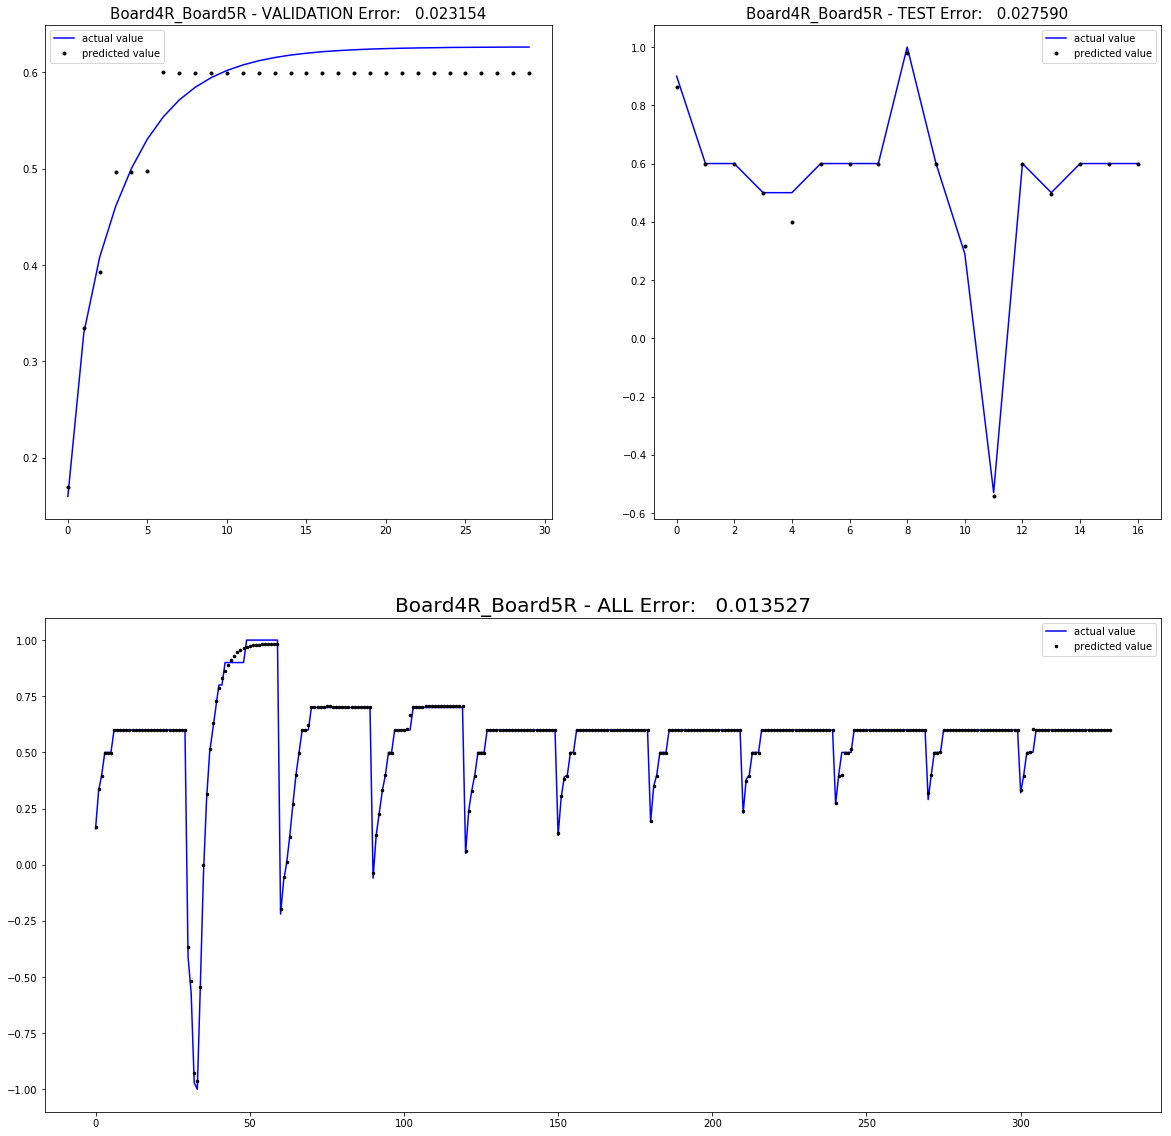

 24%|███████████████████▉                                                              | 8/33 [17:56<56:03, 134.54s/it]


 ******************************************************************************** 
 Processing output Board4R_PanelRe
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'four', 'units10': 25.63480254317195, 'batch_size': 32, 'units8': 20.83558374127786, 'learning_rate': 0.004480843305525551, 'units4': 32.69635313328085, 'dropout': 0.07678715386326815, 'units1': 49.380959694973896, 'units2': 19.08773845468363, 'units6': 17.947116003020717, 'units3': 18.35576823811705}
Error: 23.486836826009363 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'ten', 'units10': 52.12110547425272, 'batch_size': 32, 'units8': 24.987440791648112, 'learning_rate': 0.007191833588632503, 'units4': 37.70406117503305, 'dropout': 0.016365894233886902, 'units1': 48.704332930158095, 'units2': 19.93440970978621, 'units6': 41.6304899647842, 'units3': 38.350411878561246}
Error: 14.201737218810074 

Parameter optimization evalation round: 3
Params testing:  {'num_layers

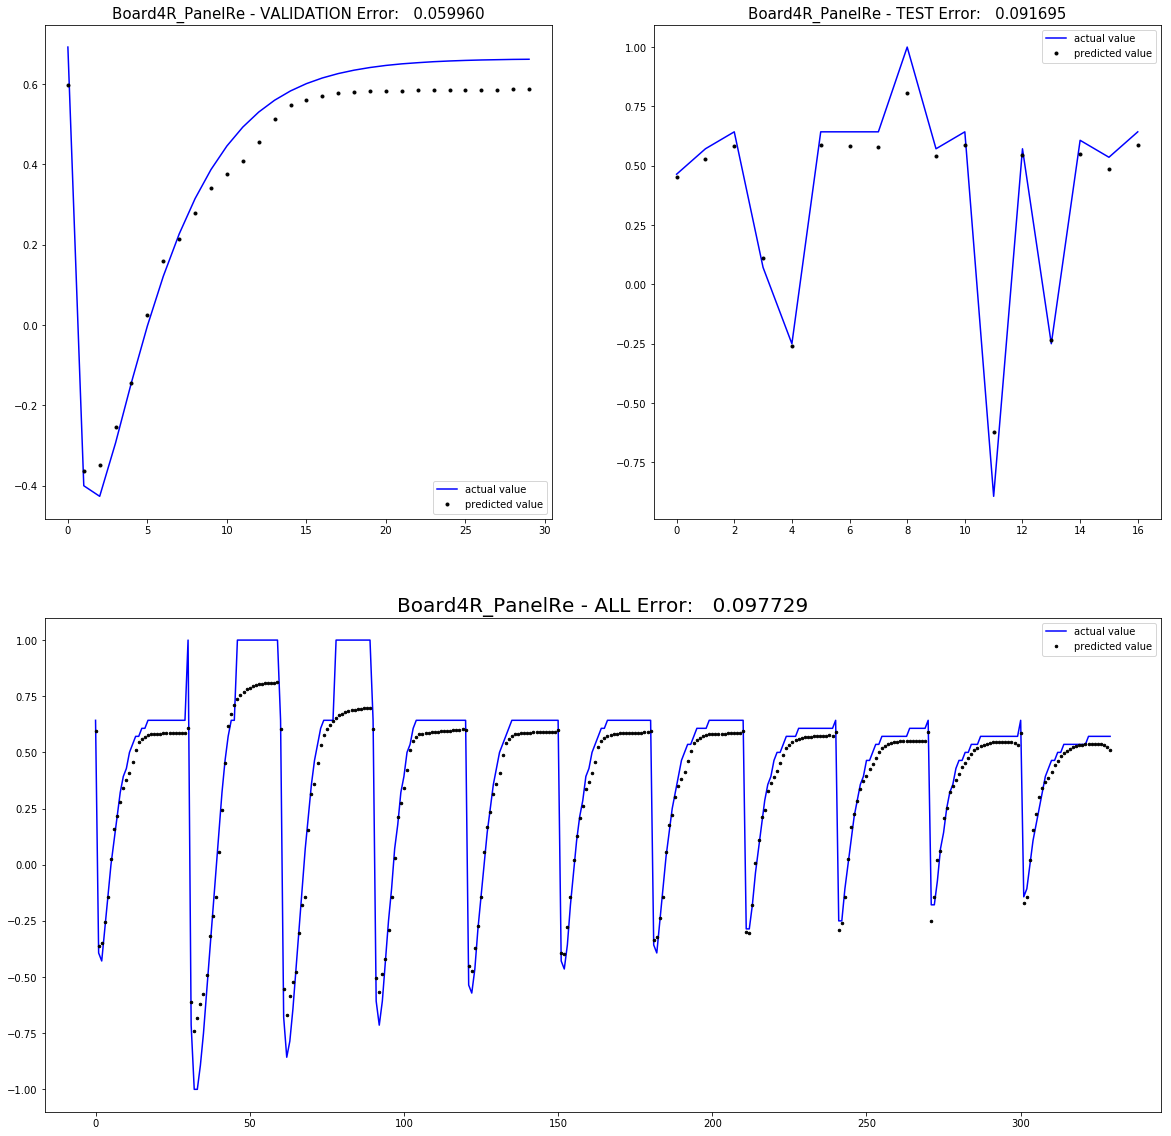

 27%|██████████████████████▎                                                           | 9/33 [22:01<58:42, 146.78s/it]


 ******************************************************************************** 
 Processing output Board5R_Board6R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'eight', 'units10': 19.99100284561488, 'batch_size': 32, 'units8': 34.461403959534664, 'learning_rate': 0.0011049685507496805, 'units4': 17.100733875868308, 'dropout': 0.0668527483152604, 'units1': 40.43314800048937, 'units2': 40.01430419344523, 'units6': 40.97111137734038, 'units3': 25.92650358196819}
Error: 120.48390601989199 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'ten', 'units10': 51.15342779771424, 'batch_size': 64, 'units8': 62.822336644971436, 'learning_rate': 0.0012317802518176824, 'units4': 47.00124870927671, 'dropout': 0.04497553477671613, 'units1': 28.959918812606517, 'units2': 47.84929194331273, 'units6': 58.38031057478211, 'units3': 45.79332231194458}
Error: 98.02877092543905 

Parameter optimization evalation round: 3
Params testing:  {'num_layers

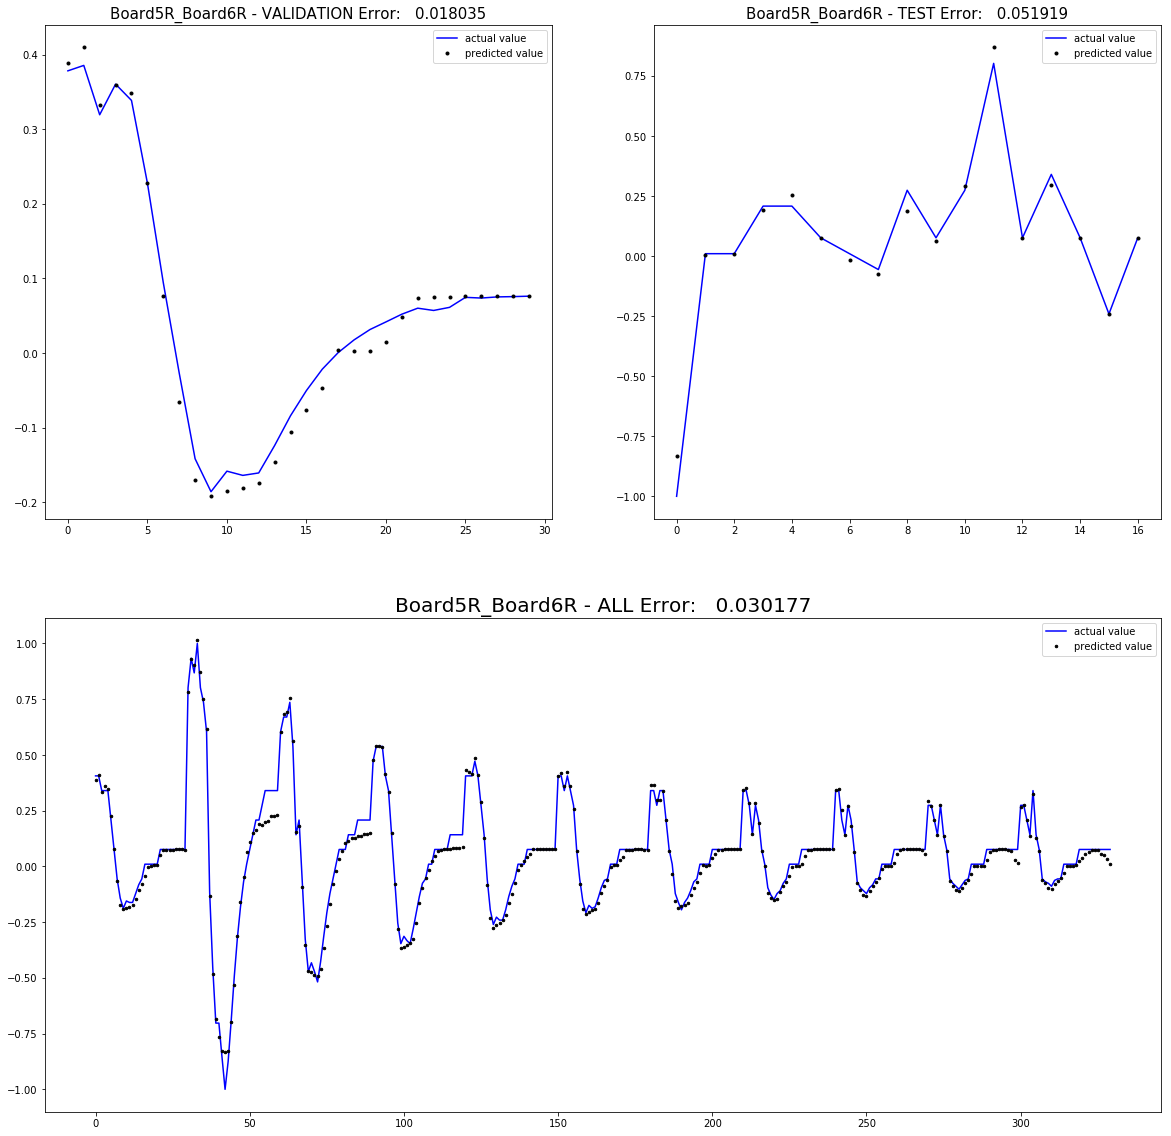

 30%|███████████████████████▉                                                       | 10/33 [26:49<1:01:41, 160.95s/it]


 ******************************************************************************** 
 Processing output Board5R_PanelRe
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'eight', 'units10': 45.41493130203303, 'batch_size': 64, 'units8': 55.82441553318489, 'learning_rate': 0.009303496271589728, 'units4': 34.654277900835524, 'dropout': 0.07972901702437013, 'units1': 63.18035433249524, 'units2': 55.83642166180859, 'units6': 39.195592800153584, 'units3': 57.27166039370688}
Error: 30.038139846069544 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'eight', 'units10': 48.82061840285229, 'batch_size': 64, 'units8': 39.98929006851526, 'learning_rate': 0.009806161313508852, 'units4': 50.073809381952444, 'dropout': 0.07989584919384685, 'units1': 17.91157054031573, 'units2': 32.07673554926388, 'units6': 45.66391367419504, 'units3': 30.199329409673695}
Error: 35.2943665180983 

Parameter optimization evalation round: 3
Params testing:  {'num_layers

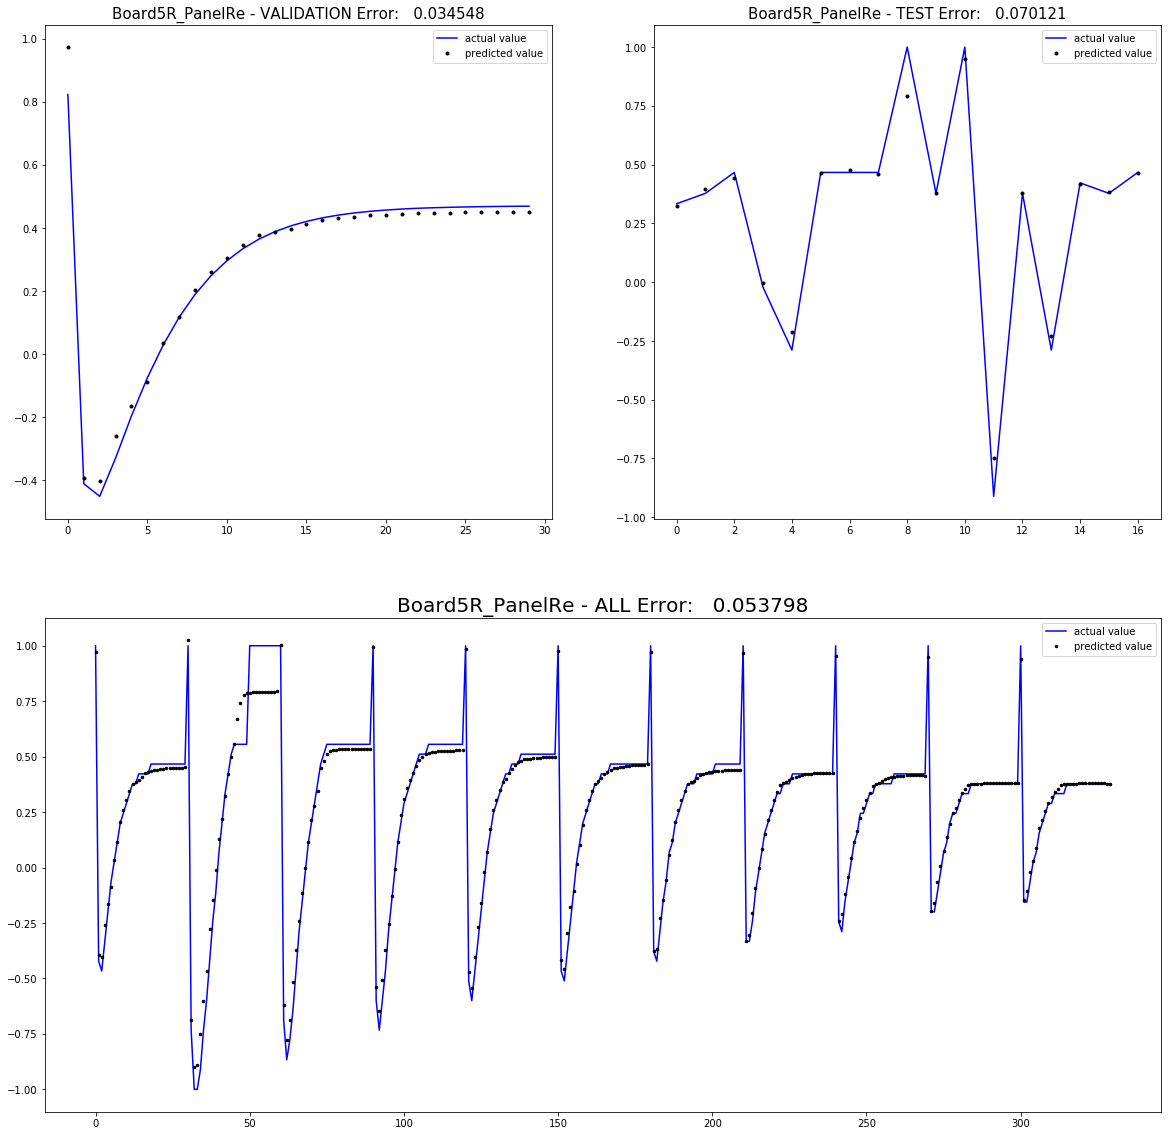

 33%|██████████████████████████▎                                                    | 11/33 [31:00<1:02:00, 169.09s/it]


 ******************************************************************************** 
 Processing output Board6R_Board7R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'ten', 'units10': 49.01564304928887, 'batch_size': 64, 'units8': 39.6496778040114, 'learning_rate': 0.005697993728888698, 'units4': 41.89001442854351, 'dropout': 0.007189555066380915, 'units1': 35.201165767893386, 'units2': 18.41192377849169, 'units6': 62.24556224692529, 'units3': 62.73828548404809}
Error: 36.30036469716277 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'eight', 'units10': 56.60747773538334, 'batch_size': 64, 'units8': 19.27499330144117, 'learning_rate': 0.009868476397107511, 'units4': 19.100896555796798, 'dropout': 0.025732486260696574, 'units1': 56.773993382189964, 'units2': 29.526040292872047, 'units6': 49.51098259648325, 'units3': 43.088272970774}
Error: 12.64456755135576 

Parameter optimization evalation round: 3
Params testing:  {'num_layers': 

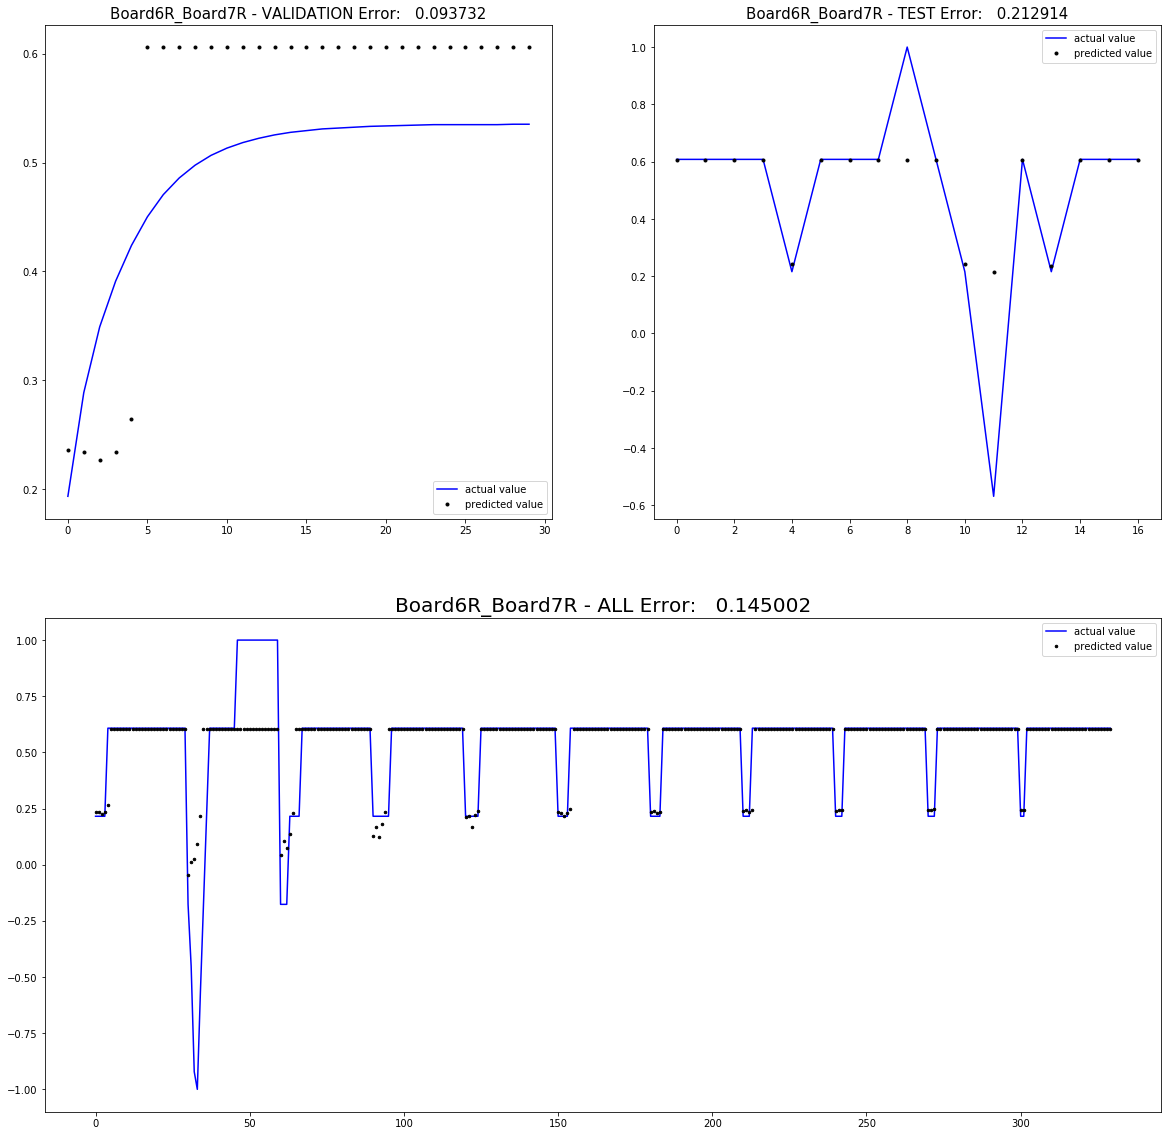

 36%|█████████████████████████████▍                                                   | 12/33 [34:13<59:53, 171.10s/it]


 ******************************************************************************** 
 Processing output Board6R_PanelRe
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'eight', 'units10': 56.68986077088279, 'batch_size': 64, 'units8': 34.715768640444566, 'learning_rate': 0.007593870421870884, 'units4': 29.659196861880105, 'dropout': 0.032435538105433474, 'units1': 56.74224338041189, 'units2': 38.666918635865535, 'units6': 59.37586995190257, 'units3': 50.00442506627466}
Error: 23.976641872386548 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'eight', 'units10': 33.58817927427819, 'batch_size': 64, 'units8': 50.016415062279165, 'learning_rate': 0.008171492774606028, 'units4': 27.835702690796335, 'dropout': 0.09241708903209685, 'units1': 33.13098173527444, 'units2': 16.312710361501885, 'units6': 42.60753669640424, 'units3': 52.96885802313454}
Error: 23.895757361468313 

Parameter optimization evalation round: 3
Params testing:  {'num_l

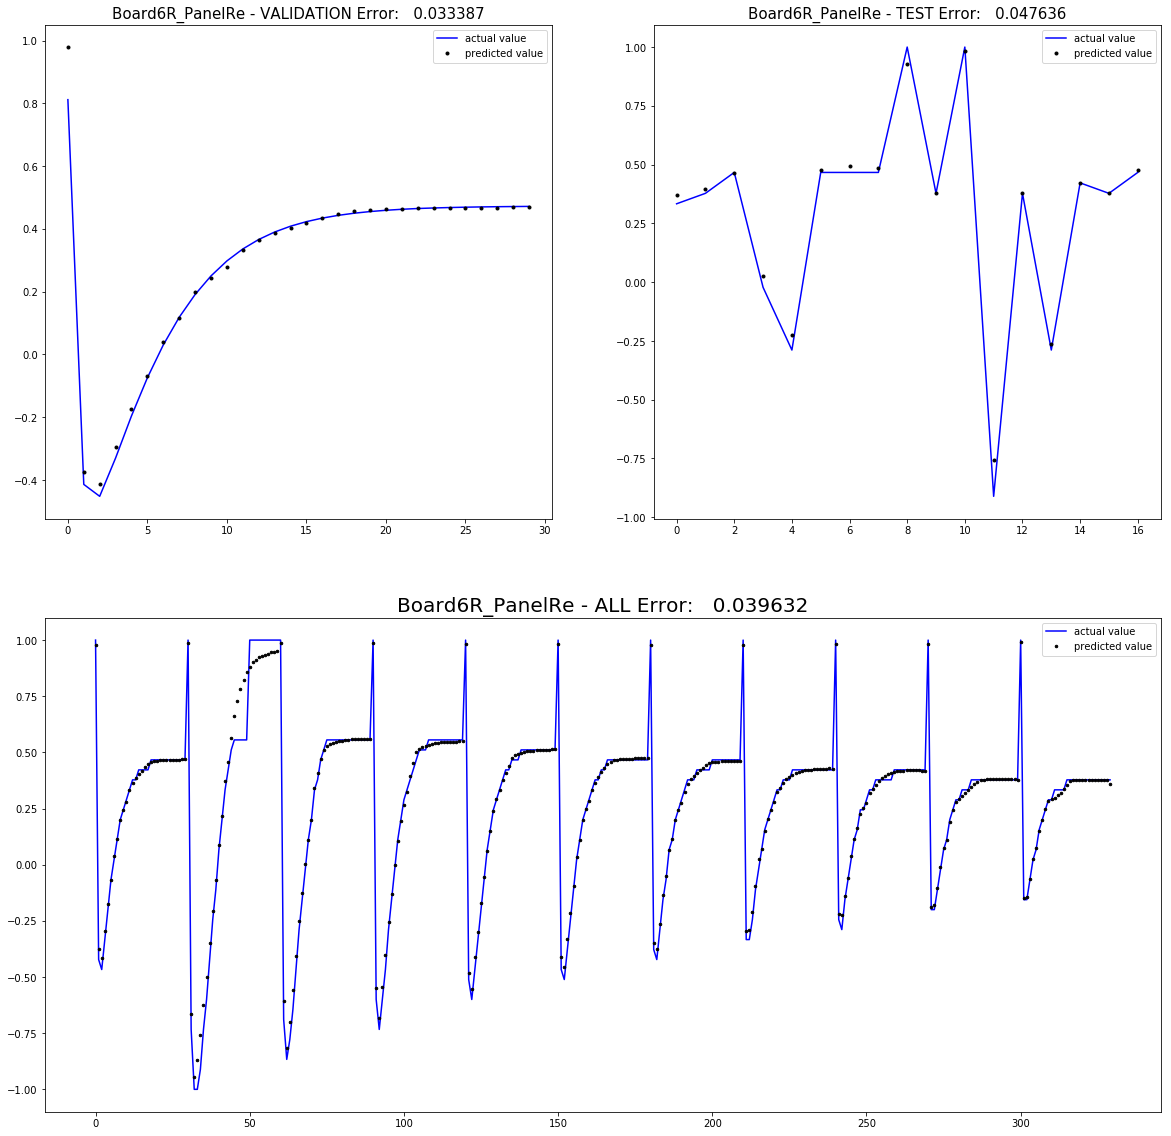

 39%|███████████████████████████████▉                                                 | 13/33 [38:10<58:44, 176.22s/it]


 ******************************************************************************** 
 Processing output Board7R_Board8R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'four', 'units10': 32.06476917543021, 'batch_size': 64, 'units8': 22.239524072251832, 'learning_rate': 0.009649245888030813, 'units4': 32.17472422775594, 'dropout': 0.02628847873592858, 'units1': 29.61098757998521, 'units2': 24.897794121984855, 'units6': 19.425812661888436, 'units3': 25.55795273983062}
Error: 0.6757820399051835 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'ten', 'units10': 19.535133699306968, 'batch_size': 64, 'units8': 47.41503767598397, 'learning_rate': 0.00612810484258278, 'units4': 60.17643017636339, 'dropout': 0.08969745750296762, 'units1': 31.091158568755027, 'units2': 57.83259472982543, 'units6': 34.389735190835815, 'units3': 51.95681647124676}
Error: 12.415578556183483 

Parameter optimization evalation round: 3
Params testing:  {'num_layers

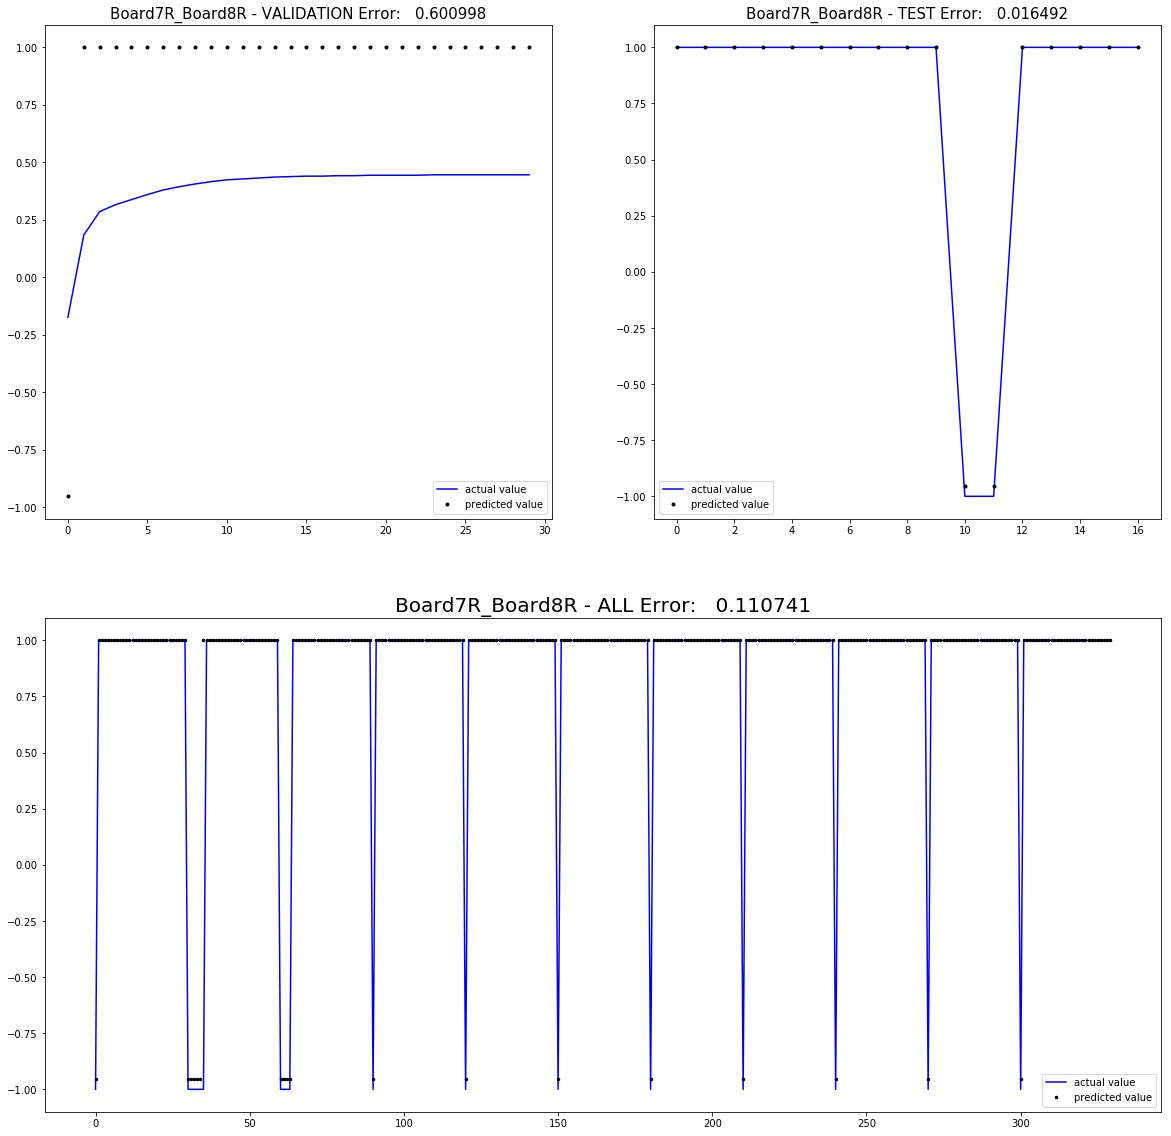

 42%|██████████████████████████████████▎                                              | 14/33 [41:27<56:15, 177.66s/it]


 ******************************************************************************** 
 Processing output Board7R_PanelRe
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'four', 'units10': 23.330327501950055, 'batch_size': 64, 'units8': 34.712849594394534, 'learning_rate': 0.009994612035206463, 'units4': 36.335243472841626, 'dropout': 0.01042000205954048, 'units1': 43.8211511973954, 'units2': 17.165556433253762, 'units6': 43.16920053897807, 'units3': 45.062364129546985}
Error: 7.407519069461865 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'ten', 'units10': 29.205613668991774, 'batch_size': 32, 'units8': 49.357597731504924, 'learning_rate': 0.006660476210750377, 'units4': 37.130306119593854, 'dropout': 0.016456987658577584, 'units1': 28.453605563982297, 'units2': 32.11610505830686, 'units6': 25.33111921140405, 'units3': 41.53544289830461}
Error: 15.573510414585343 

Parameter optimization evalation round: 3
Params testing:  {'num_lay

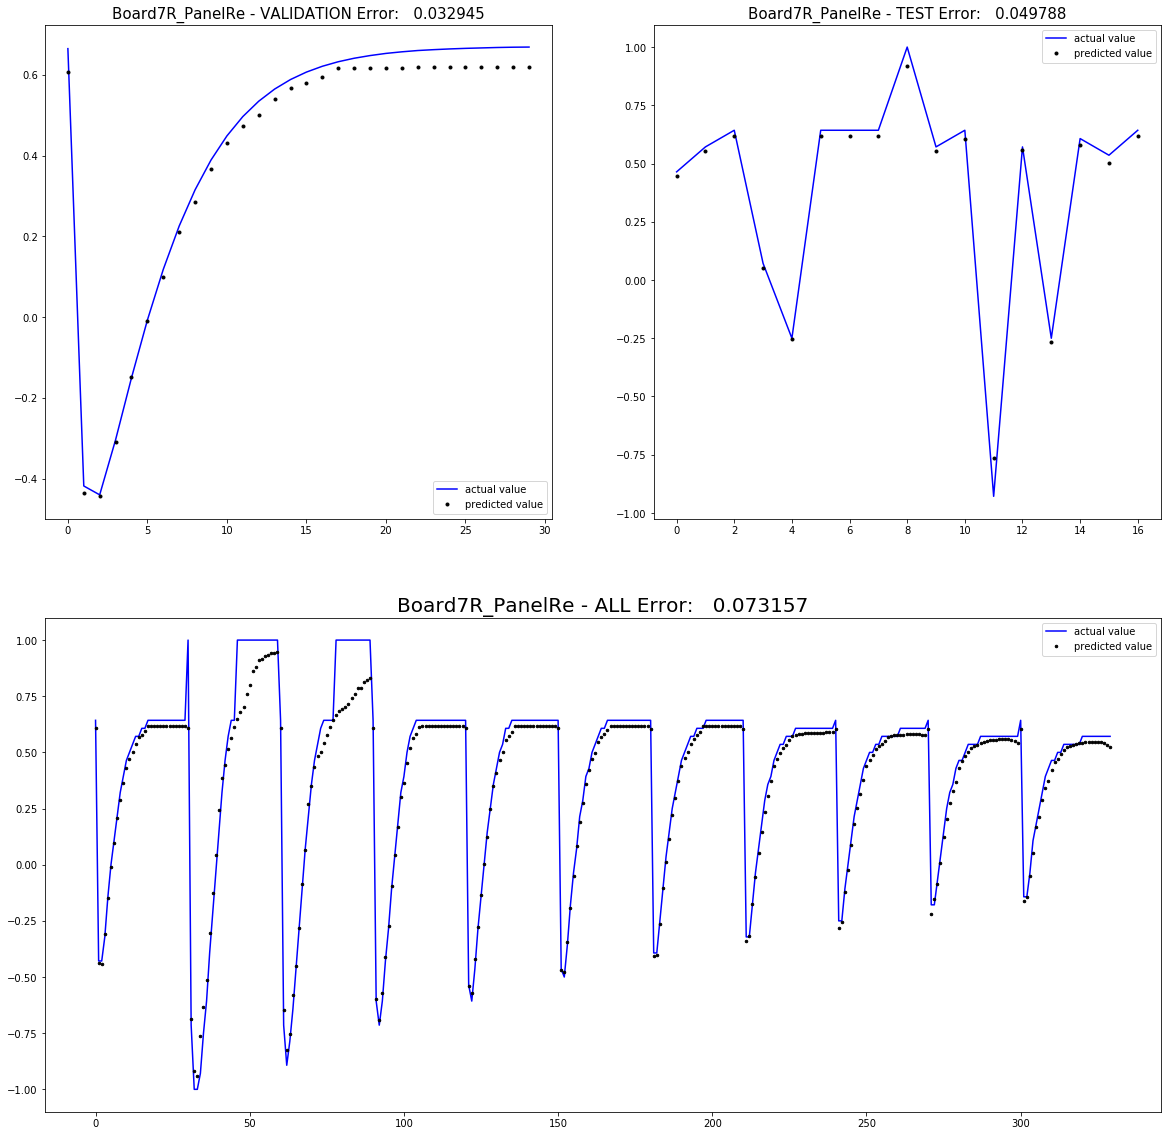

 45%|████████████████████████████████████▊                                            | 15/33 [45:20<54:25, 181.39s/it]


 ******************************************************************************** 
 Processing output Board8R_Board9R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'eight', 'units10': 38.23473852332934, 'batch_size': 32, 'units8': 35.11786929639048, 'learning_rate': 0.006520283726896167, 'units4': 46.47387444677, 'dropout': 0.05940232822238276, 'units1': 50.71569028697834, 'units2': 51.52753125318307, 'units6': 62.02488286451127, 'units3': 35.35411043563118}
Error: 12.717664695804833 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'eight', 'units10': 48.365841961186625, 'batch_size': 32, 'units8': 52.26900116009633, 'learning_rate': 0.009785581684148413, 'units4': 62.538435949847916, 'dropout': 0.01021058982319857, 'units1': 24.342846847471463, 'units2': 35.66643156028675, 'units6': 30.377267271616795, 'units3': 31.050199935783567}
Error: 6.186565087896889 

Parameter optimization evalation round: 3
Params testing:  {'num_layers'

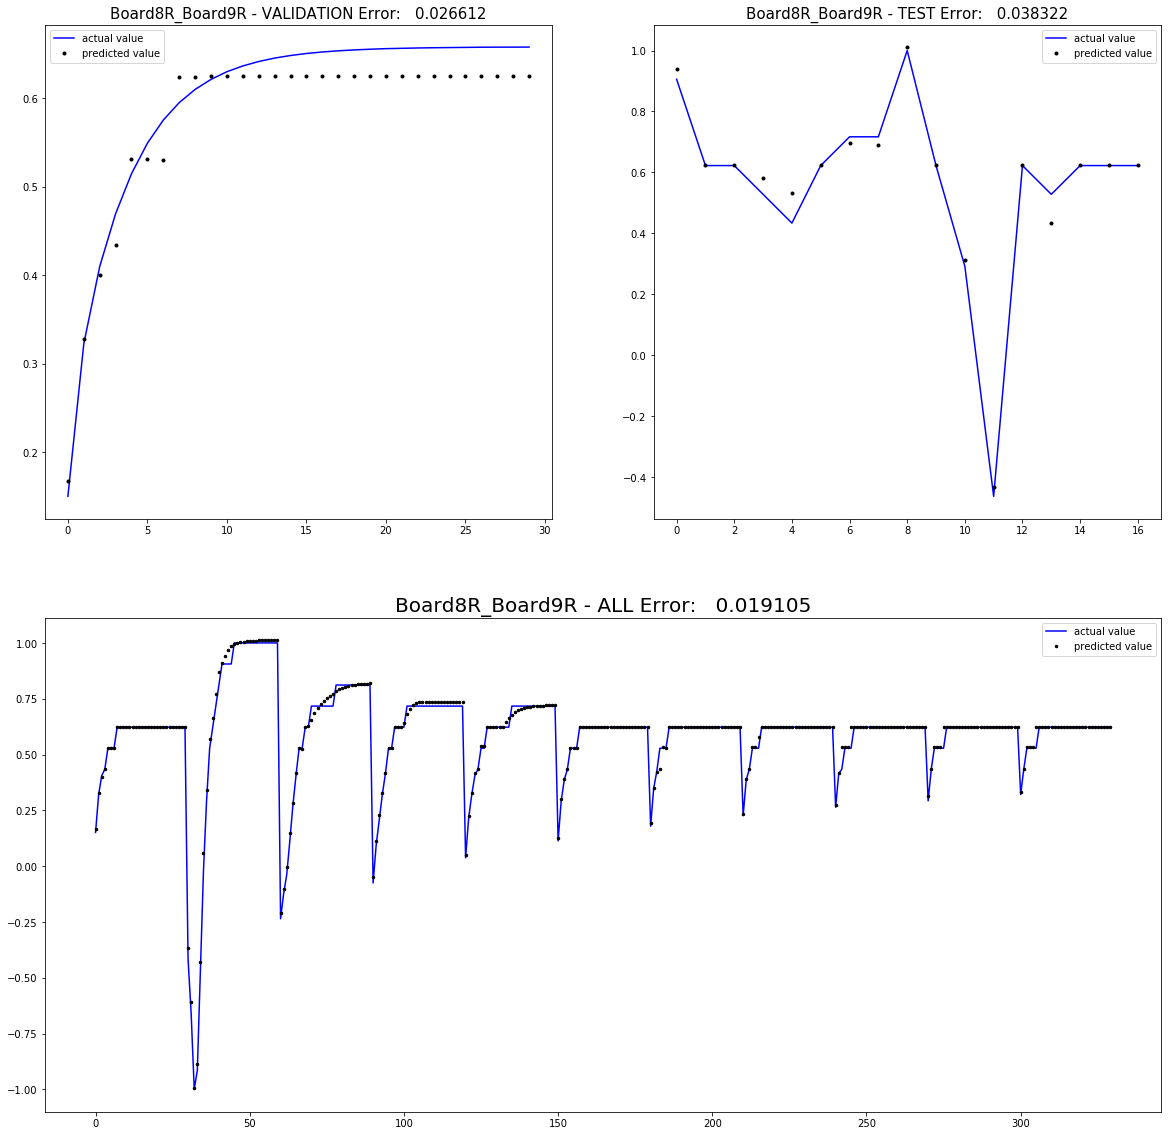

 48%|███████████████████████████████████████▎                                         | 16/33 [52:00<55:15, 195.03s/it]


 ******************************************************************************** 
 Processing output Board8R_PanelRe
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'four', 'units10': 40.92913035366749, 'batch_size': 32, 'units8': 17.282613400332934, 'learning_rate': 0.008678382734043439, 'units4': 43.53802451810436, 'dropout': 0.09271715302086936, 'units1': 24.39017128535501, 'units2': 29.16832154103009, 'units6': 28.293194802640595, 'units3': 53.36967015240912}
Error: 22.14256353247951 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'four', 'units10': 56.84050554714254, 'batch_size': 32, 'units8': 46.222314616587646, 'learning_rate': 0.0068765240142068, 'units4': 16.845712171485335, 'dropout': 0.0037364568860674963, 'units1': 32.86467219424152, 'units2': 37.24706131108027, 'units6': 52.201085094423405, 'units3': 39.30183998565735}
Error: 8.658895143678423 

Parameter optimization evalation round: 3
Params testing:  {'num_layers'

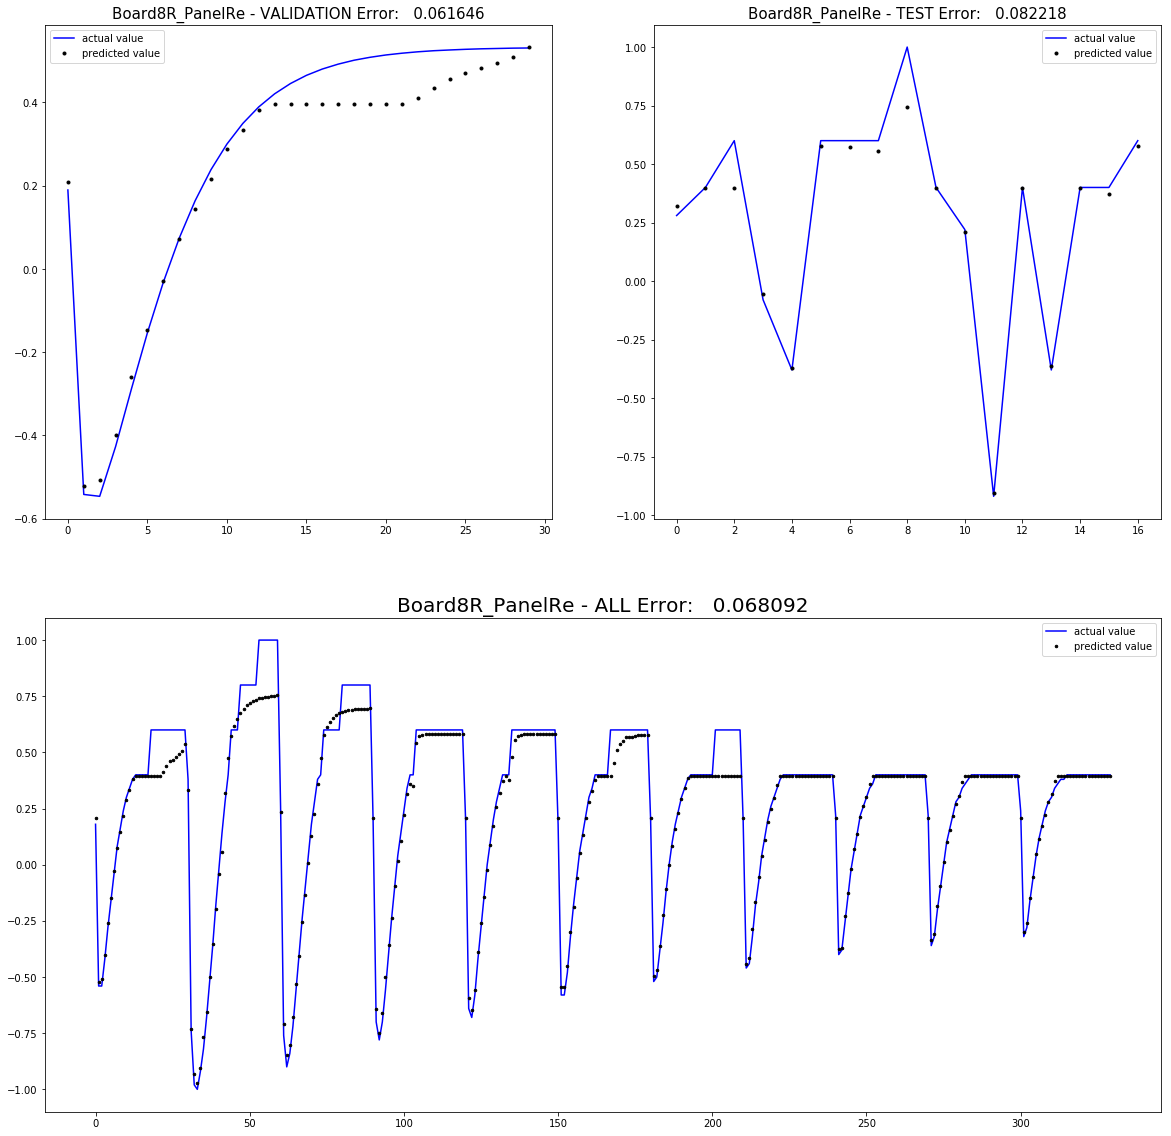

 52%|█████████████████████████████████████████▋                                       | 17/33 [58:18<54:52, 205.78s/it]


 ******************************************************************************** 
 Processing output Board9R_Board10
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'four', 'units10': 50.18255937060934, 'batch_size': 32, 'units8': 37.093939459435454, 'learning_rate': 0.00414797173937175, 'units4': 47.87211860009759, 'dropout': 0.0877349384553233, 'units1': 47.77740222300447, 'units2': 46.557593398925604, 'units6': 53.696658985083644, 'units3': 24.330380561572124}
Error: 9.441421558239965 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'six', 'units10': 29.161551719629188, 'batch_size': 32, 'units8': 23.295751085514823, 'learning_rate': 0.006102597409401211, 'units4': 51.59221571780436, 'dropout': 0.08034591882207771, 'units1': 54.21050290374317, 'units2': 56.21315614513424, 'units6': 47.80001146248128, 'units3': 61.45429467246223}
Error: 15.067516853905314 

Parameter optimization evalation round: 3
Params testing:  {'num_layers':

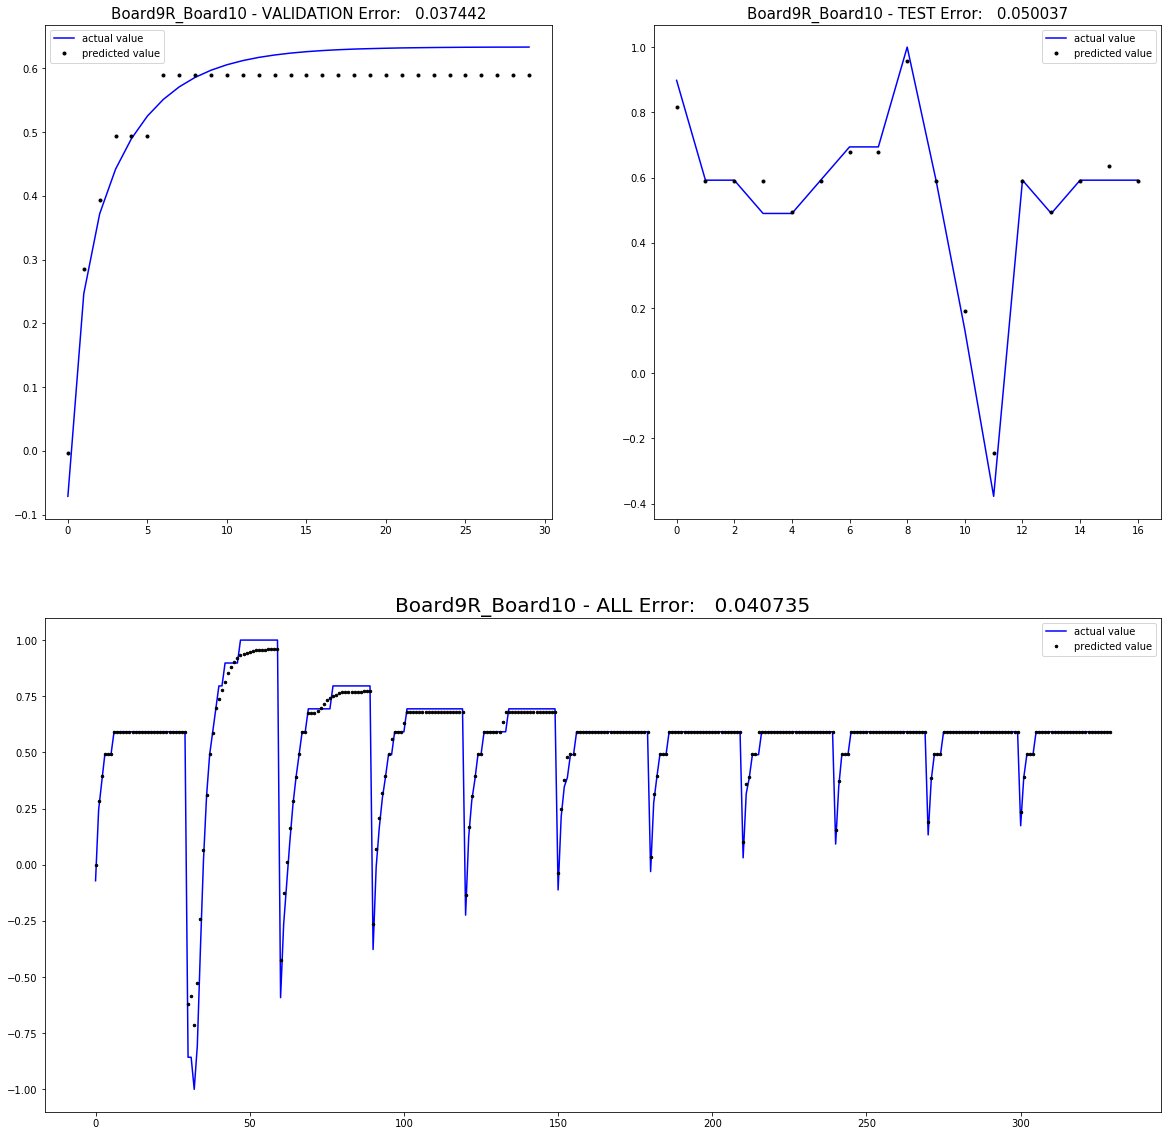

 55%|███████████████████████████████████████████                                    | 18/33 [1:04:09<53:28, 213.87s/it]


 ******************************************************************************** 
 Processing output Board9R_PanelRe
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'four', 'units10': 56.65115656529616, 'batch_size': 32, 'units8': 56.97892335116657, 'learning_rate': 0.00744796967421847, 'units4': 21.948782129423627, 'dropout': 0.09235233684106012, 'units1': 61.885559050568396, 'units2': 24.47400788013293, 'units6': 42.26200595942575, 'units3': 18.01336331305089}
Error: 19.5984408922592 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'ten', 'units10': 42.582977162720944, 'batch_size': 32, 'units8': 27.742751602918915, 'learning_rate': 0.008349843275973884, 'units4': 51.096706054221535, 'dropout': 0.07500375389273439, 'units1': 33.40092160474897, 'units2': 21.747282558943567, 'units6': 49.1731022100234, 'units3': 39.25446788192596}
Error: 34.67759437345392 

Parameter optimization evalation round: 3
Params testing:  {'num_layers': '

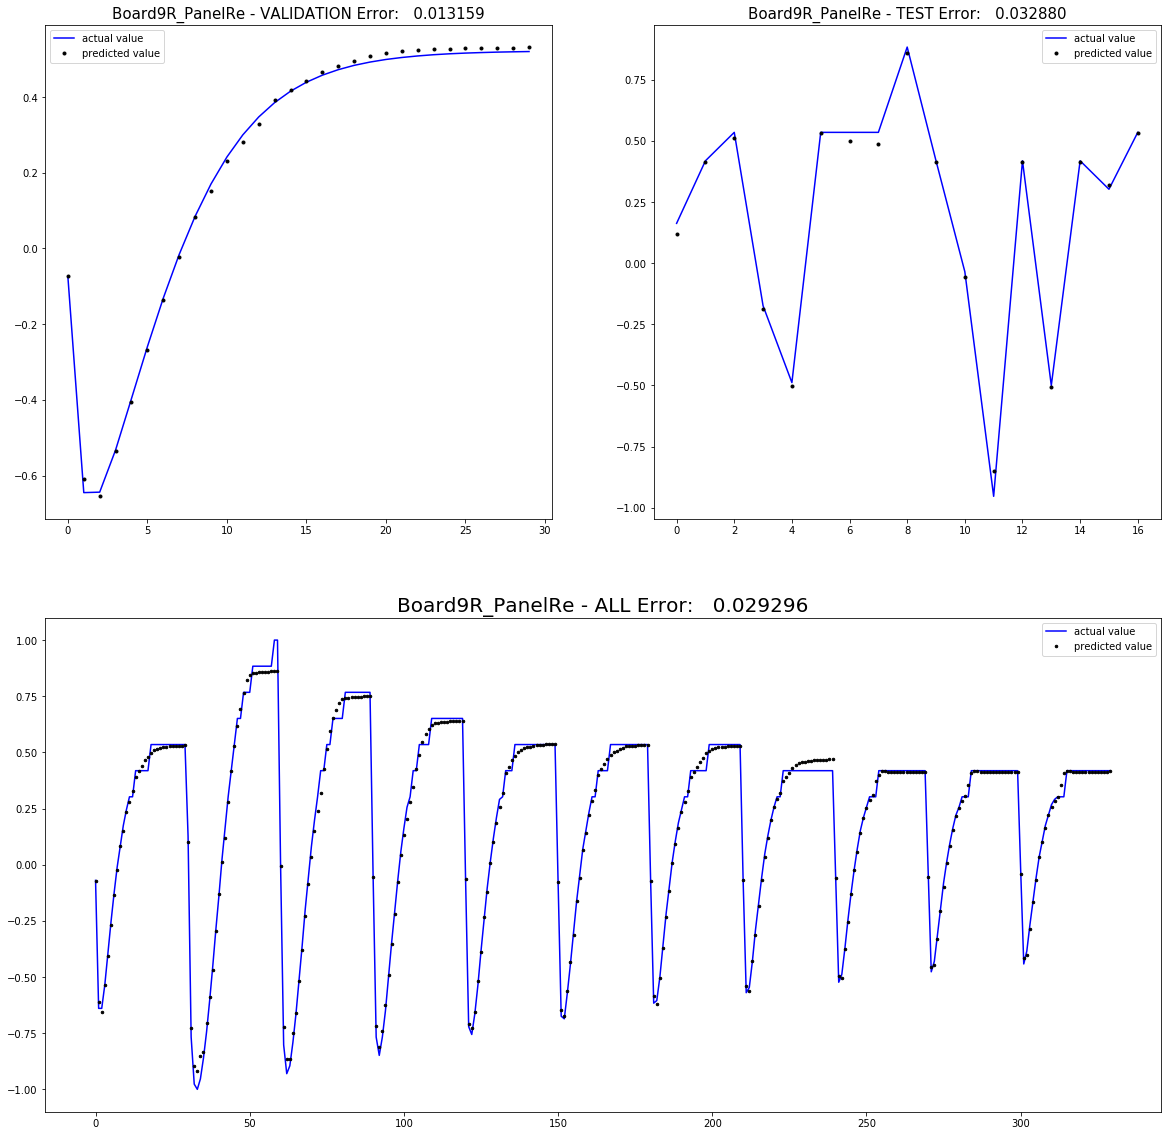

 58%|█████████████████████████████████████████████▍                                 | 19/33 [1:09:44<51:23, 220.22s/it]


 ******************************************************************************** 
 Processing output Board10_PanelRe
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'six', 'units10': 19.51054714738529, 'batch_size': 32, 'units8': 28.73848863974046, 'learning_rate': 0.0022967373422173453, 'units4': 16.889947913802466, 'dropout': 0.004128504878938644, 'units1': 30.671941205745085, 'units2': 40.1976385972786, 'units6': 39.200219791435295, 'units3': 47.11535013485456}
Error: 55.05292167270884 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'eight', 'units10': 20.70450031610551, 'batch_size': 64, 'units8': 50.17743760534121, 'learning_rate': 0.006429954572864916, 'units4': 44.71778536865389, 'dropout': 0.024510856529728155, 'units1': 16.103896010947633, 'units2': 55.412939797244874, 'units6': 21.35143448765247, 'units3': 54.65989336417492}
Error: 35.44255246906684 

Parameter optimization evalation round: 3
Params testing:  {'num_layer

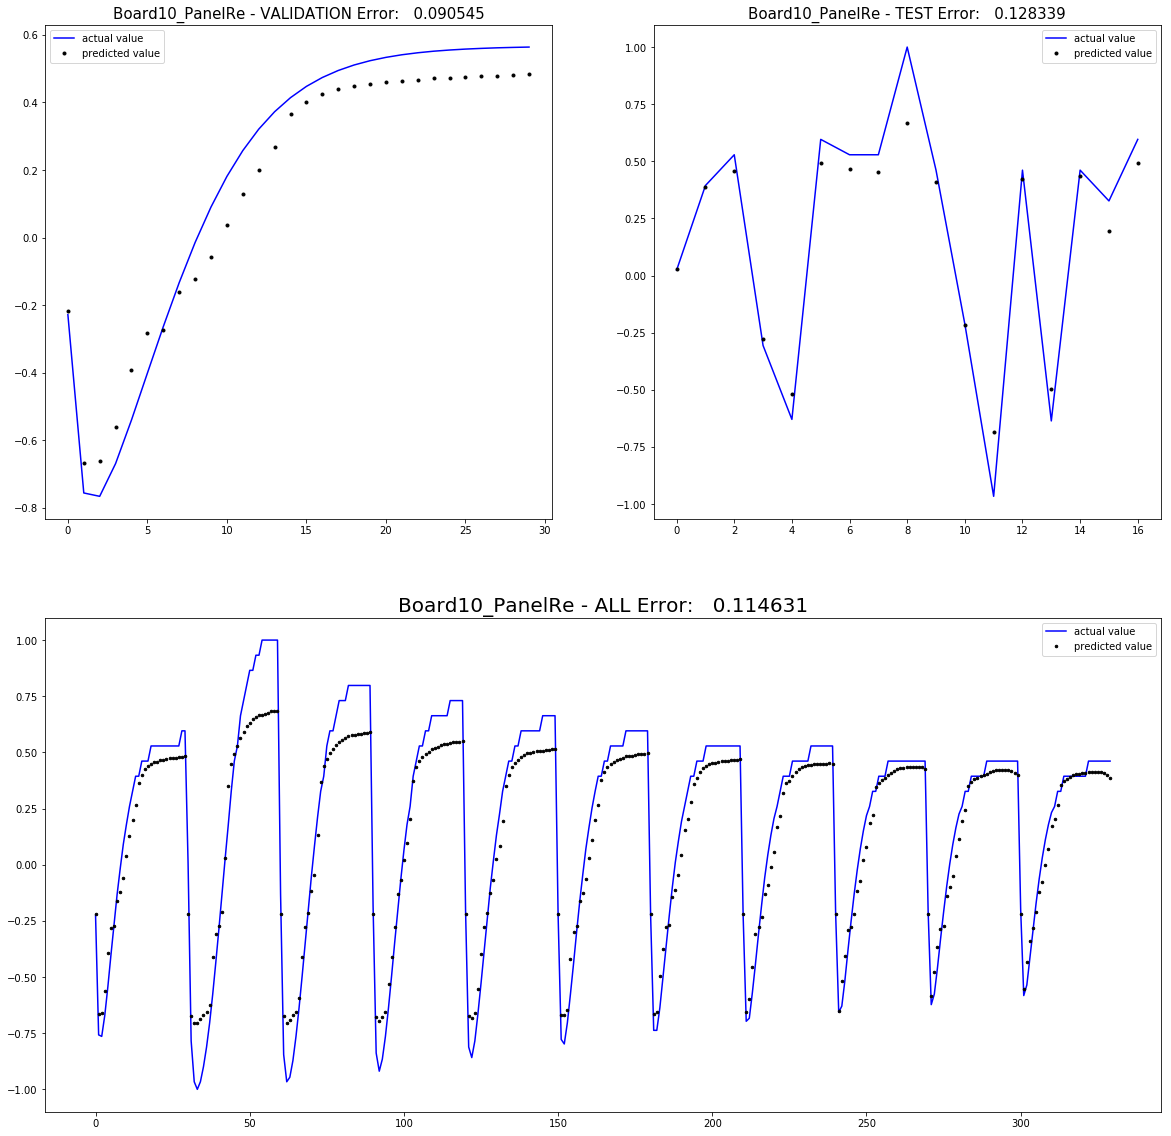

 61%|███████████████████████████████████████████████▉                               | 20/33 [1:16:26<49:40, 229.30s/it]


 ******************************************************************************** 
 Processing output Board10_Cover1R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'six', 'units10': 57.03641087344663, 'batch_size': 32, 'units8': 35.755840706765106, 'learning_rate': 0.007664882441345402, 'units4': 20.258615000626122, 'dropout': 0.049501118803454175, 'units1': 34.8712782644284, 'units2': 54.61661164010945, 'units6': 47.47617800621946, 'units3': 20.313803495384555}
Error: 4.8964134962634684 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'six', 'units10': 55.846983849754466, 'batch_size': 32, 'units8': 58.45363780322969, 'learning_rate': 0.00845788333933439, 'units4': 37.15029241241102, 'dropout': 0.08163320105334843, 'units1': 32.626718003971845, 'units2': 28.43568446136468, 'units6': 23.442840717352063, 'units3': 37.808524562719214}
Error: 5.460907493717821 

Parameter optimization evalation round: 3
Params testing:  {'num_layers'

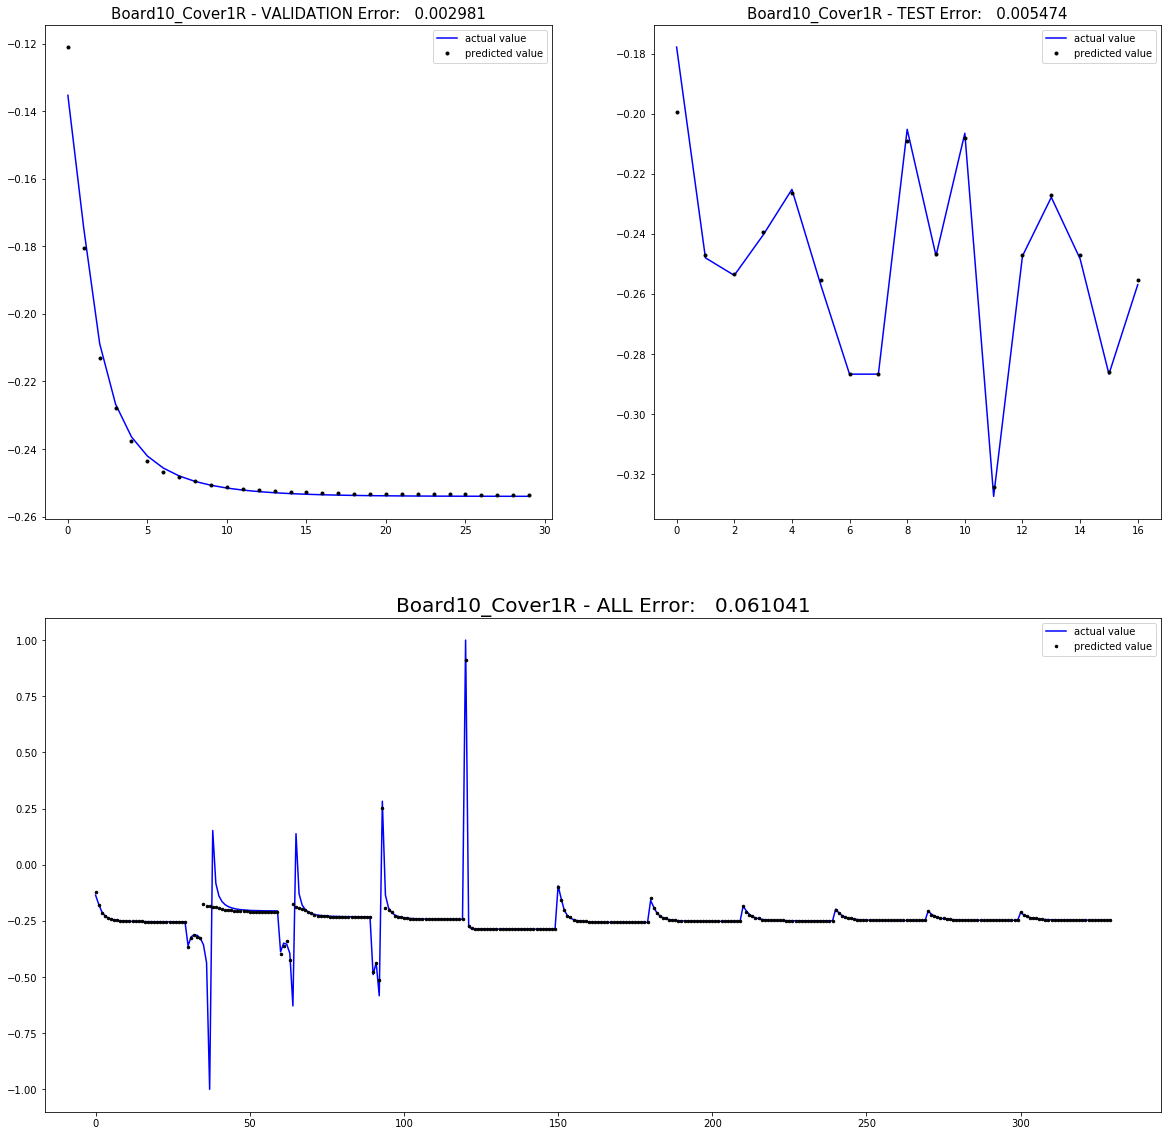

 64%|██████████████████████████████████████████████████▎                            | 21/33 [1:21:20<46:28, 232.39s/it]


 ******************************************************************************** 
 Processing output PanelRe_Cover1R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'four', 'units10': 55.77451910258377, 'batch_size': 32, 'units8': 38.5122459703819, 'learning_rate': 0.0022492461661818217, 'units4': 22.603696863862787, 'dropout': 0.00918201761920875, 'units1': 22.476482374165904, 'units2': 18.807899223524934, 'units6': 38.63930152831962, 'units3': 43.50735181071041}
Error: 164.976969583224 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'four', 'units10': 37.76221557186282, 'batch_size': 32, 'units8': 39.537384920429766, 'learning_rate': 0.008621512648403551, 'units4': 62.0426829375797, 'dropout': 0.08868913073217677, 'units1': 40.36485355977881, 'units2': 24.863504367253036, 'units6': 39.57773332803089, 'units3': 62.192376513660555}
Error: 365.297892809189 

Parameter optimization evalation round: 3
Params testing:  {'num_layers': 

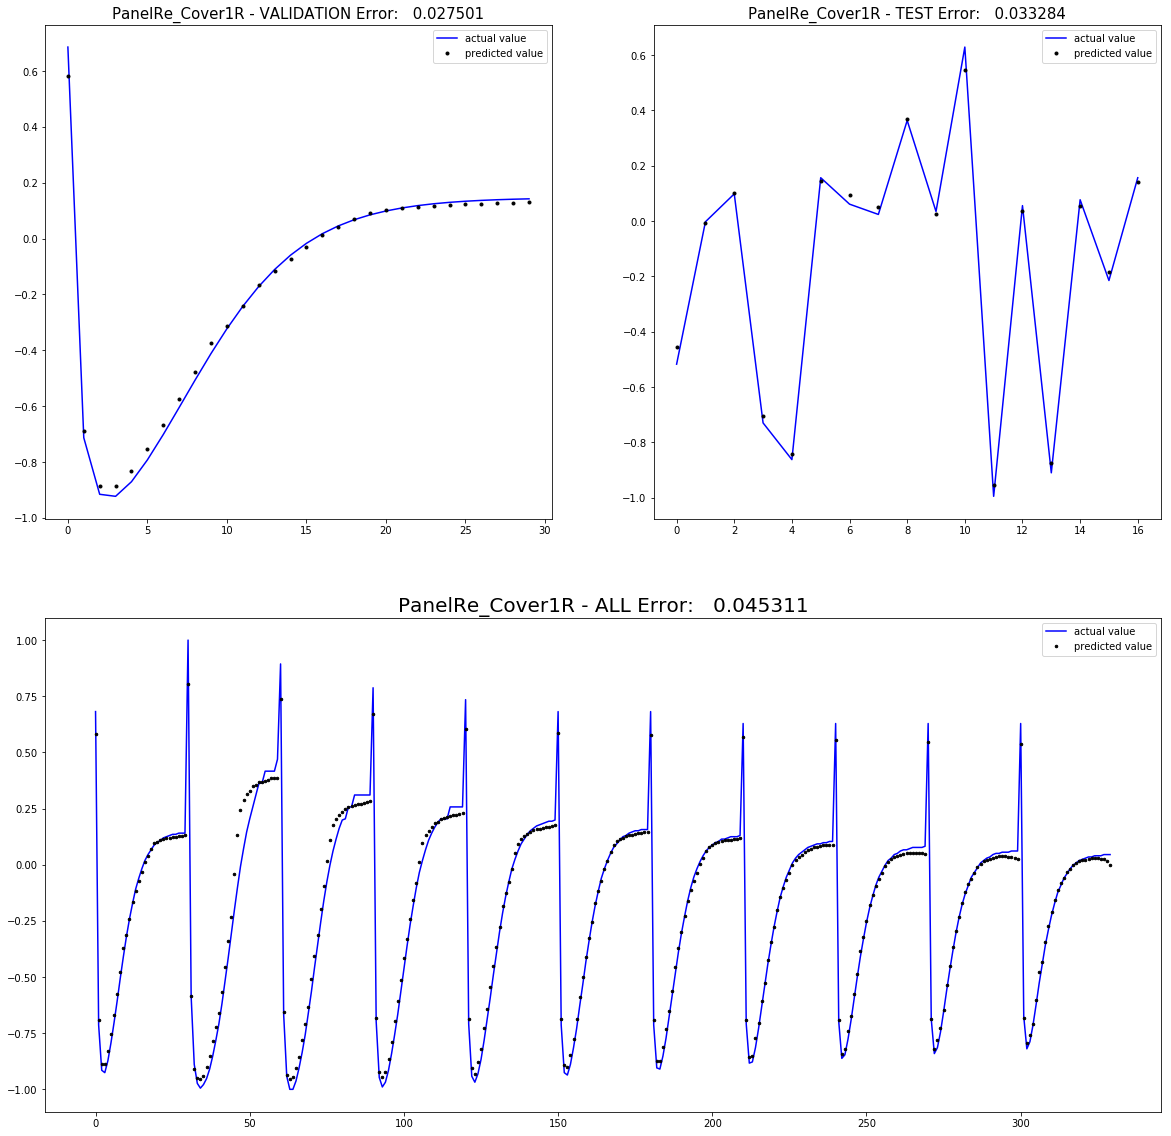

 67%|████████████████████████████████████████████████████▋                          | 22/33 [1:29:34<44:47, 244.28s/it]


 ******************************************************************************** 
 Processing output PanelRe_Cover2R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'ten', 'units10': 37.105393998353854, 'batch_size': 32, 'units8': 29.51074775055794, 'learning_rate': 0.007610696051572093, 'units4': 25.757555881566425, 'dropout': 0.08891265996031272, 'units1': 55.86295975403769, 'units2': 30.034877194525894, 'units6': 51.669584028078795, 'units3': 17.600144301601595}
Error: 8.869821309805701 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'eight', 'units10': 22.47111403626691, 'batch_size': 64, 'units8': 41.83270003677718, 'learning_rate': 0.005281778133698999, 'units4': 22.755460431997385, 'dropout': 0.08267804505167903, 'units1': 53.439753726082856, 'units2': 59.338334998348635, 'units6': 55.373643535657116, 'units3': 51.6329757810814}
Error: 5.760761503568061 

Parameter optimization evalation round: 3
Params testing:  {'num_laye

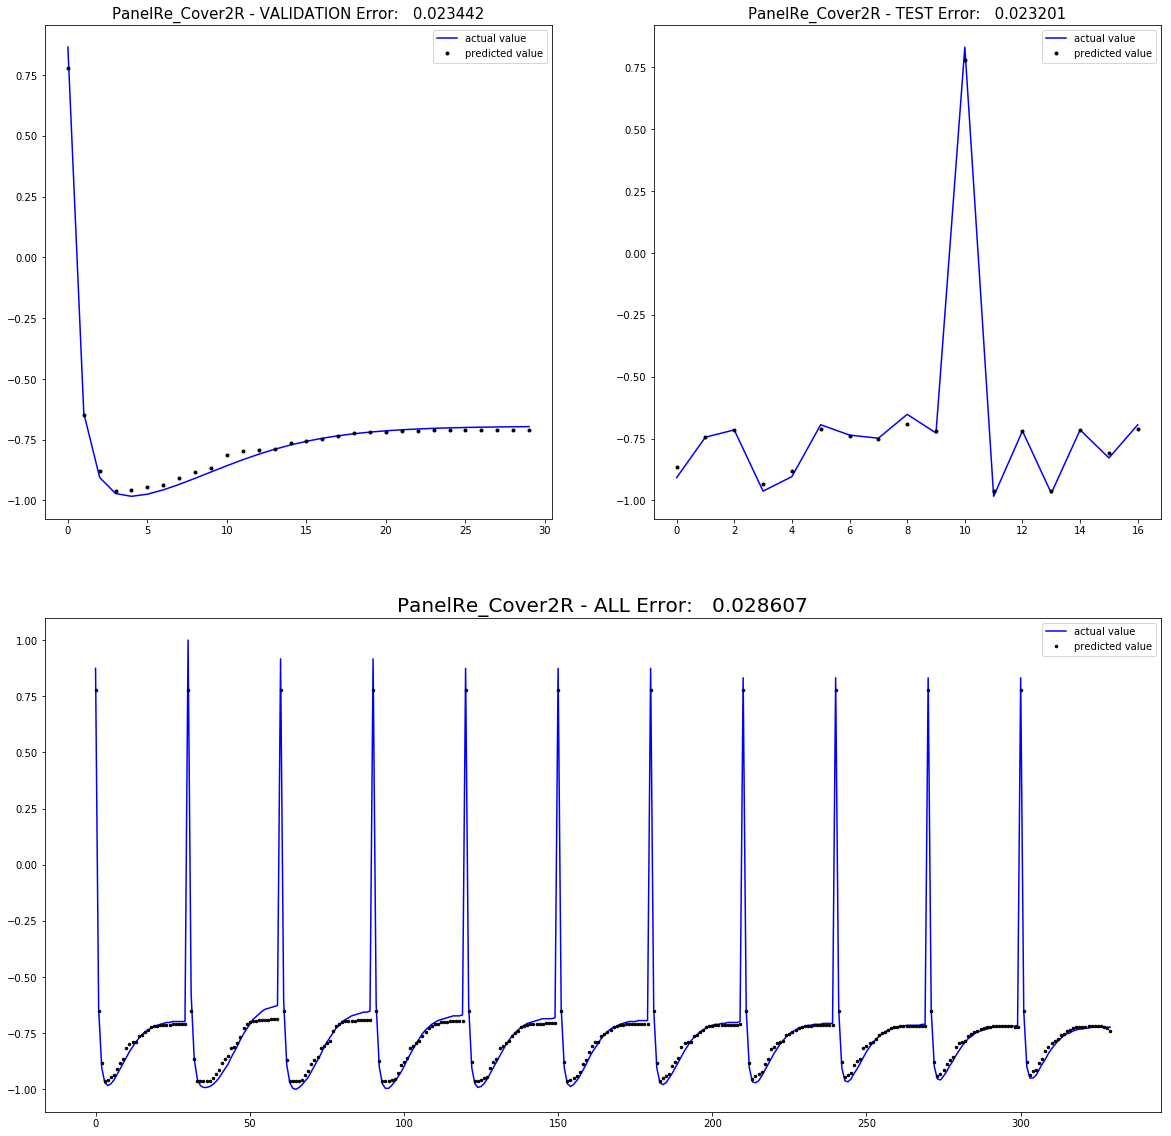

 70%|███████████████████████████████████████████████████████                        | 23/33 [1:40:24<43:39, 261.93s/it]


 ******************************************************************************** 
 Processing output PanelRe_Cover3R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'four', 'units10': 43.54393147604682, 'batch_size': 32, 'units8': 46.02794863774234, 'learning_rate': 0.0064430795229345784, 'units4': 59.173706078997114, 'dropout': 0.0734686177487395, 'units1': 18.85089350475831, 'units2': 37.8047486922009, 'units6': 47.18825528277561, 'units3': 35.76334761617394}
Error: 102.83142868267872 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'eight', 'units10': 38.905079329504076, 'batch_size': 32, 'units8': 45.89620535281833, 'learning_rate': 0.0031559725924584967, 'units4': 63.41908399123125, 'dropout': 0.01786684800031837, 'units1': 26.434364184416868, 'units2': 62.29331685440823, 'units6': 46.23470881751577, 'units3': 50.19905153540069}
Error: 119.90150911120767 

Parameter optimization evalation round: 3
Params testing:  {'num_layers

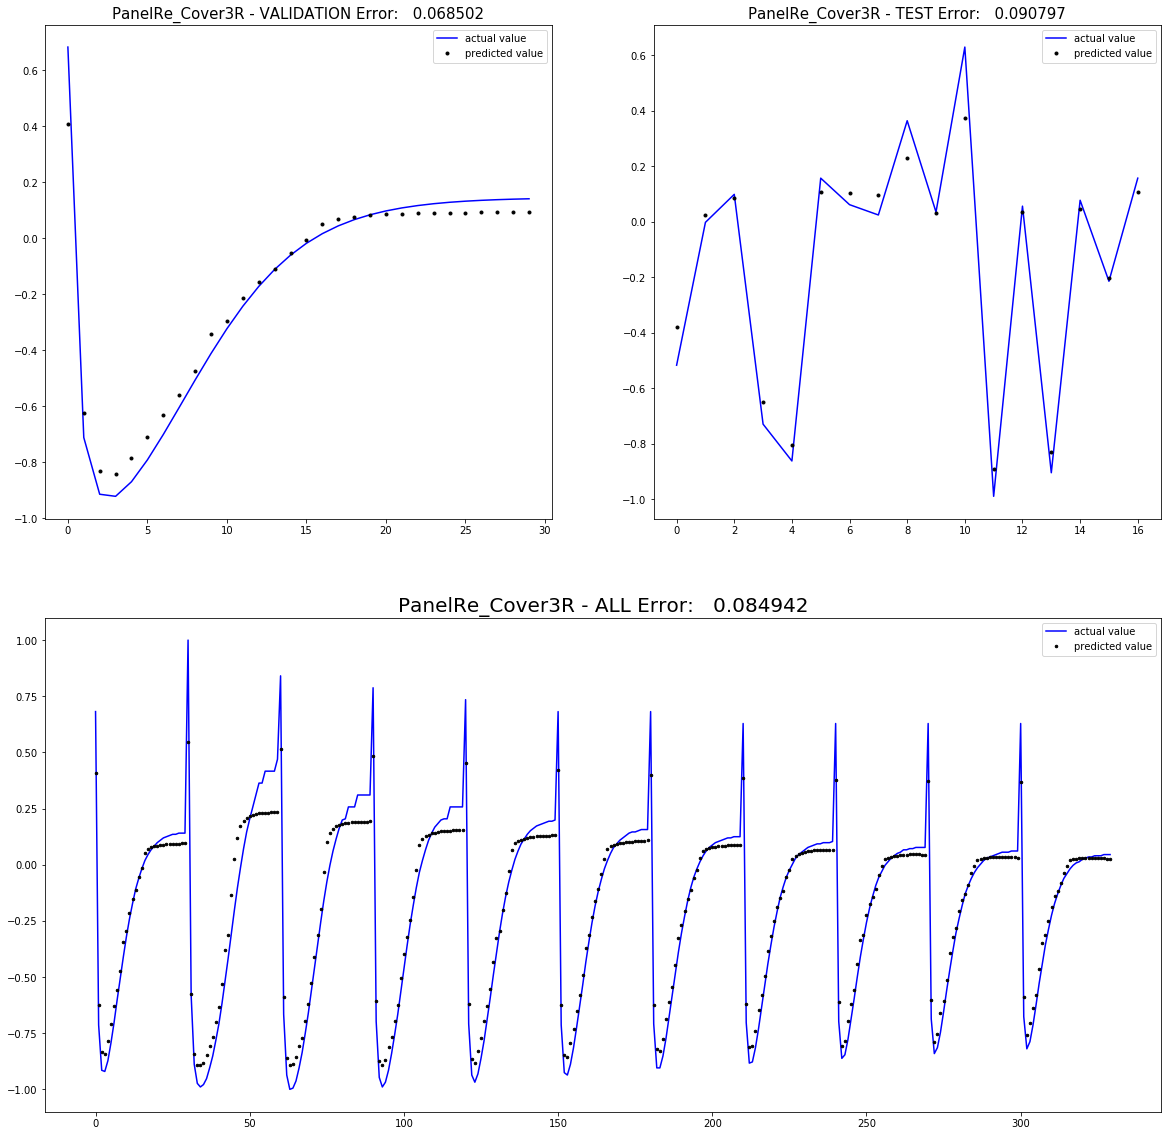

 73%|█████████████████████████████████████████████████████████▍                     | 24/33 [1:49:16<40:58, 273.17s/it]


 ******************************************************************************** 
 Processing output PanelRe_Cover4R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'six', 'units10': 39.98031917711879, 'batch_size': 32, 'units8': 51.393892249452776, 'learning_rate': 0.004630093605802827, 'units4': 17.599932332863474, 'dropout': 0.08671472420302467, 'units1': 20.229879334926927, 'units2': 22.25965194874295, 'units6': 42.56208813923567, 'units3': 24.821242271221916}
Error: 4.969336296440311 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'four', 'units10': 55.69800266457609, 'batch_size': 32, 'units8': 27.37327945454846, 'learning_rate': 0.00458299897996923, 'units4': 19.082145679111807, 'dropout': 0.07088671726892623, 'units1': 63.413455228549296, 'units2': 44.76247417761829, 'units6': 40.65593762876665, 'units3': 31.383547427503316}
Error: 3.770597842765789 

Parameter optimization evalation round: 3
Params testing:  {'num_layers'

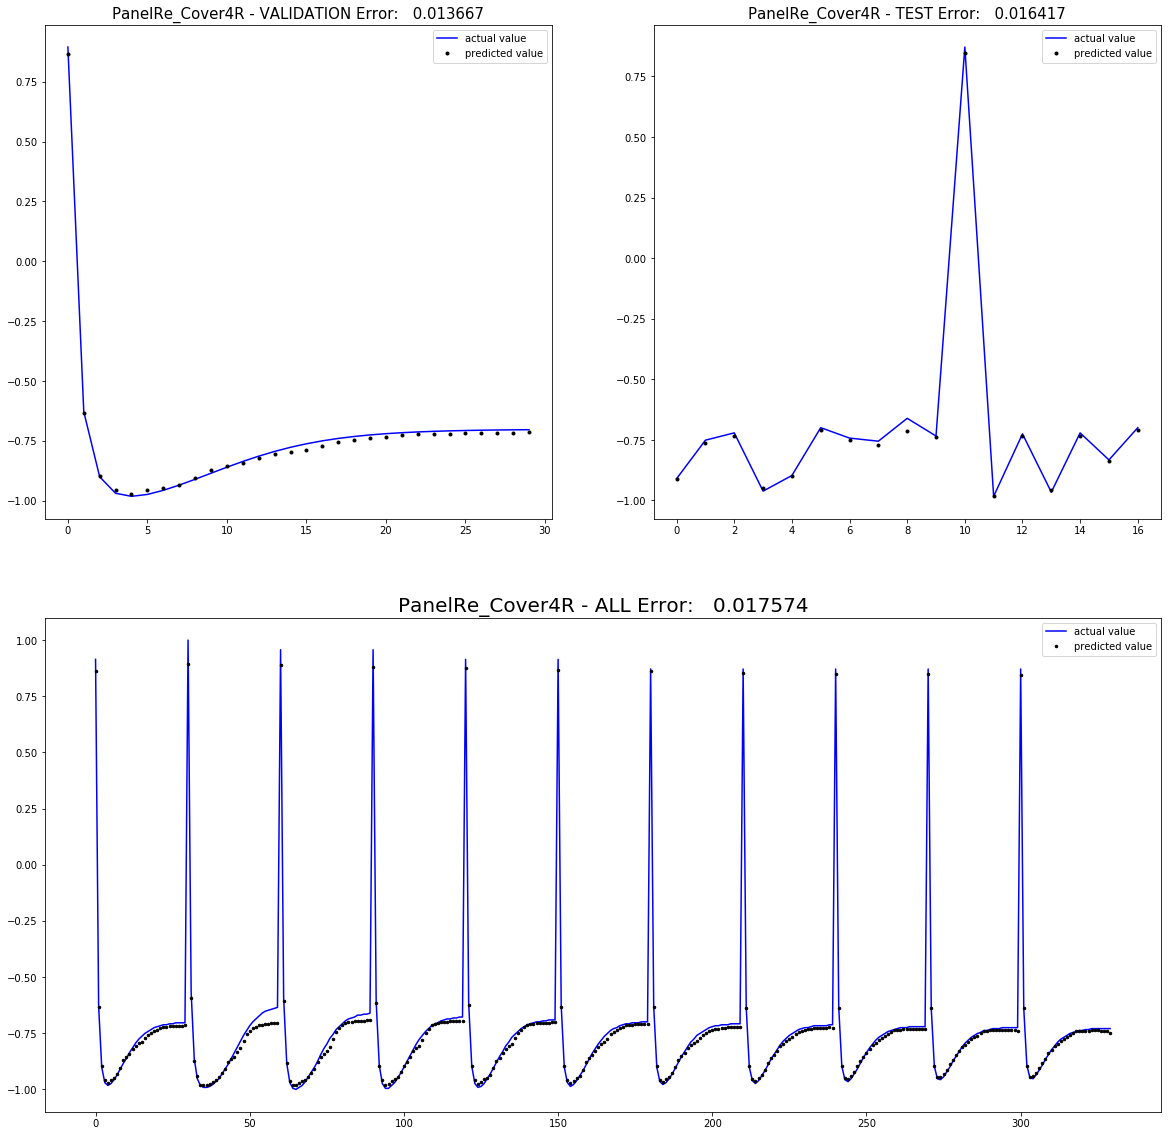

 76%|███████████████████████████████████████████████████████████▊                   | 25/33 [1:59:31<38:14, 286.86s/it]


 ******************************************************************************** 
 Processing output Cover1R_Cover2R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'eight', 'units10': 42.34398587539444, 'batch_size': 32, 'units8': 26.321139190708145, 'learning_rate': 0.00947094823705186, 'units4': 49.855493064397855, 'dropout': 0.07934885626371413, 'units1': 63.97794684807304, 'units2': 20.664854388469806, 'units6': 60.052658414552134, 'units3': 28.097348846641005}
Error: 11.945098298496939 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'six', 'units10': 32.462336734131355, 'batch_size': 64, 'units8': 41.451965520044766, 'learning_rate': 0.009323948266333124, 'units4': 28.940719856392832, 'dropout': 0.03543786286284565, 'units1': 47.271690539704224, 'units2': 51.886599675664165, 'units6': 34.465855936378425, 'units3': 38.50585774448009}
Error: 5.632608899535339 

Parameter optimization evalation round: 3
Params testing:  {'num_l

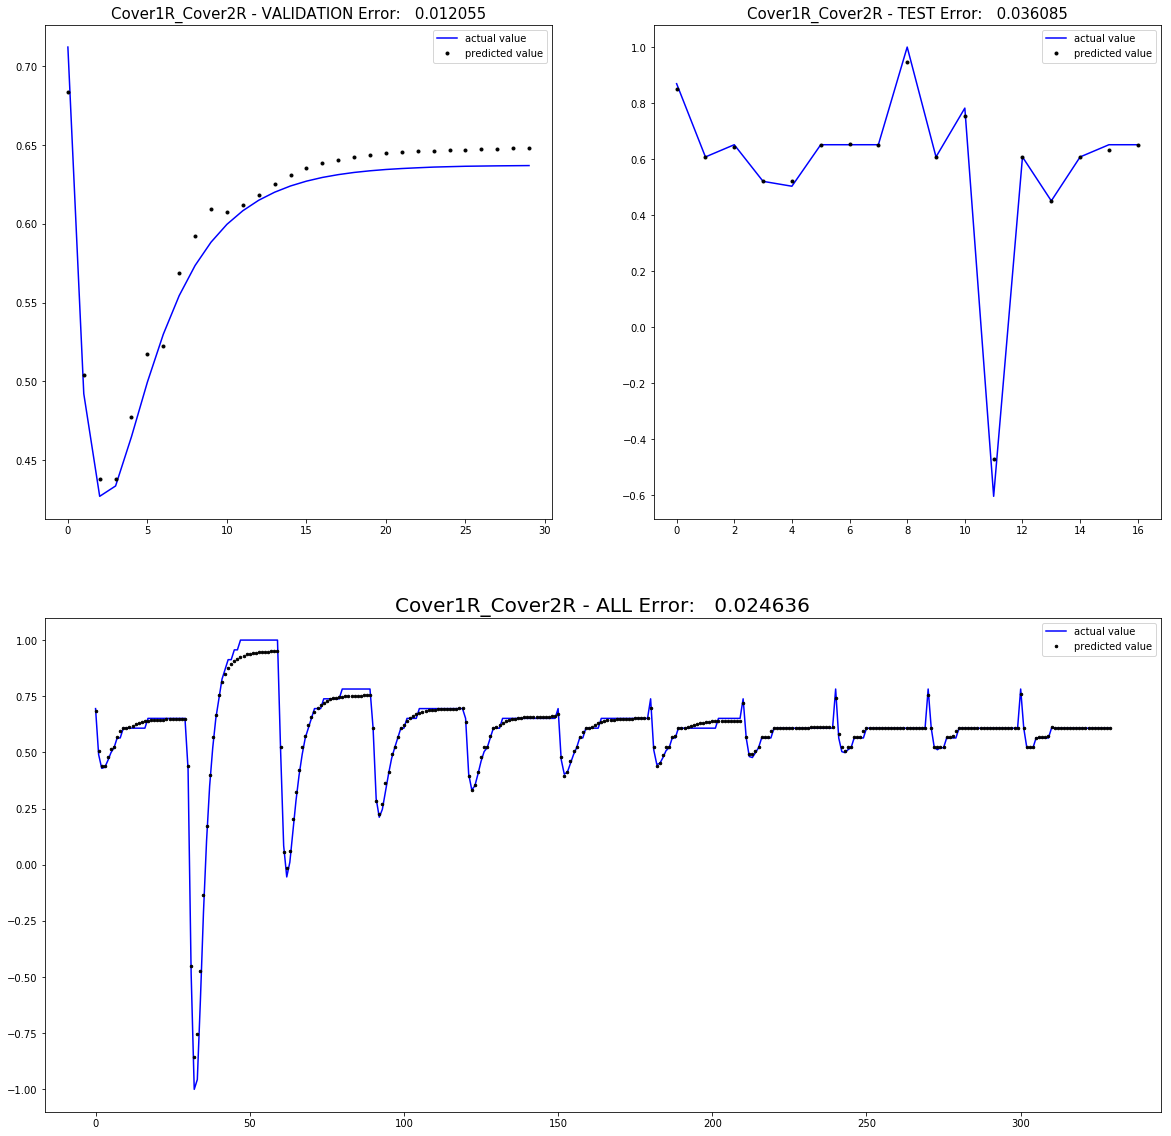

 79%|██████████████████████████████████████████████████████████████▏                | 26/33 [2:10:33<35:09, 301.29s/it]


 ******************************************************************************** 
 Processing output Cover1R_Cover4R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'six', 'units10': 41.30607756667296, 'batch_size': 32, 'units8': 35.484207542004285, 'learning_rate': 0.009802946700555228, 'units4': 60.121664186140116, 'dropout': 0.011234628917550693, 'units1': 42.819877720741644, 'units2': 26.690790136183434, 'units6': 38.077228459153645, 'units3': 17.79333879053122}
Error: 4.690647361234188 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'four', 'units10': 40.94411552387486, 'batch_size': 64, 'units8': 34.87847310284853, 'learning_rate': 0.004465209254789329, 'units4': 58.93801858345395, 'dropout': 0.05826385203719401, 'units1': 22.015154682074677, 'units2': 50.20282835533062, 'units6': 57.10904773128133, 'units3': 43.562204174861854}
Error: 5.021844188990874 

Parameter optimization evalation round: 3
Params testing:  {'num_layer

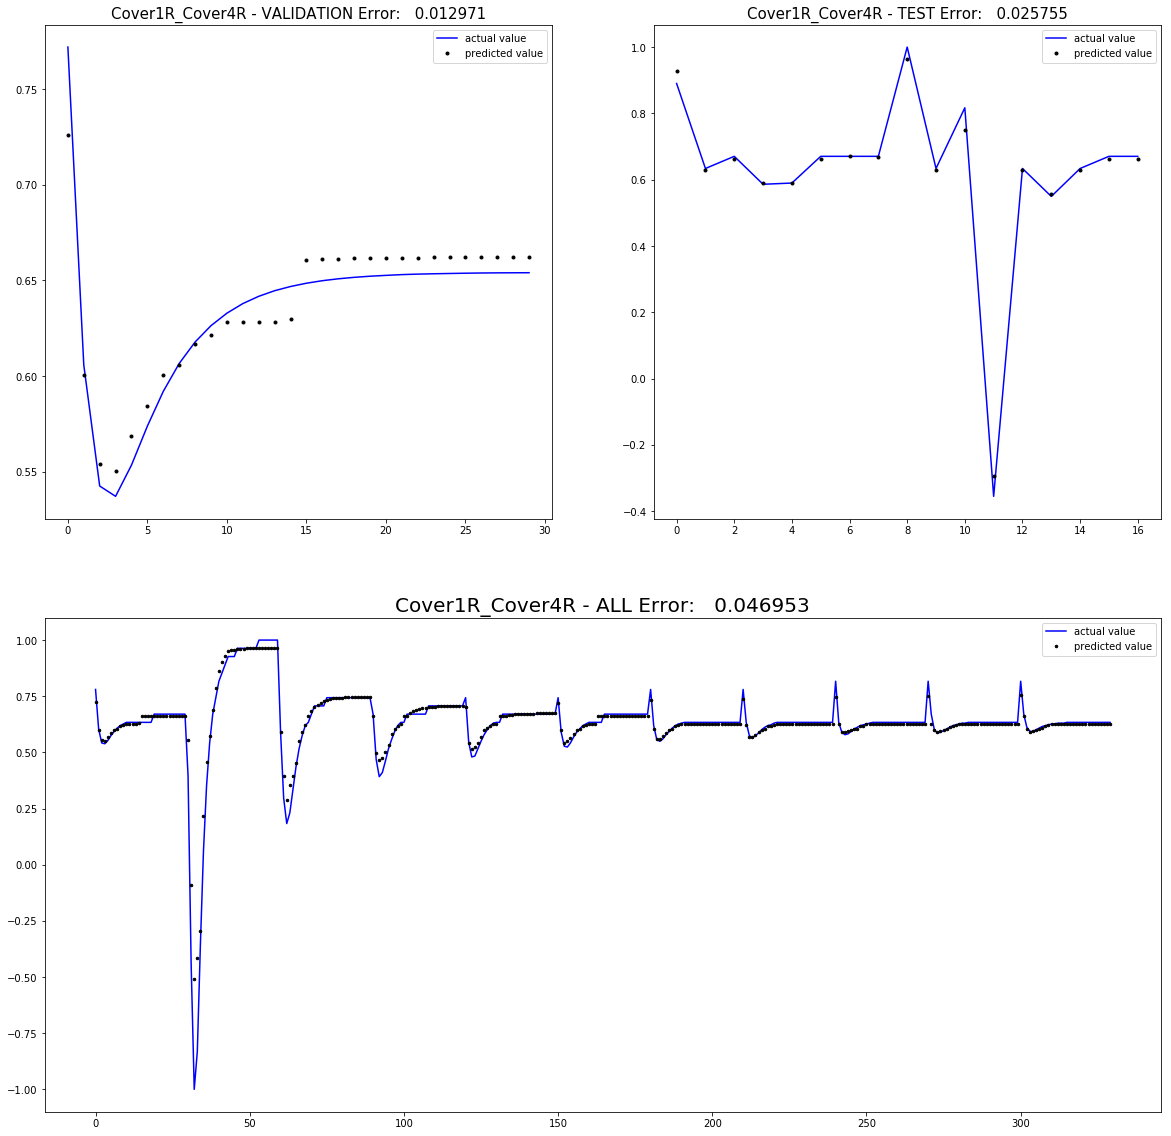

 82%|████████████████████████████████████████████████████████████████▋              | 27/33 [2:20:25<31:12, 312.05s/it]


 ******************************************************************************** 
 Processing output Cover1R_Cover5R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'six', 'units10': 41.275631230824516, 'batch_size': 64, 'units8': 53.61582907332112, 'learning_rate': 0.006200699357509138, 'units4': 53.13272935536911, 'dropout': 0.04326062983354843, 'units1': 47.29368114002956, 'units2': 26.20165927786816, 'units6': 27.196169588431967, 'units3': 46.91966680700216}
Error: 34.372648993107575 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'four', 'units10': 49.67536036475109, 'batch_size': 32, 'units8': 54.958767562322414, 'learning_rate': 0.007379414449002153, 'units4': 59.15812295437202, 'dropout': 0.0971619224999605, 'units1': 53.24103781938972, 'units2': 55.275999079114264, 'units6': 52.82664974928065, 'units3': 46.0809399567497}
Error: 29.94122764080172 

Parameter optimization evalation round: 3
Params testing:  {'num_layers': '

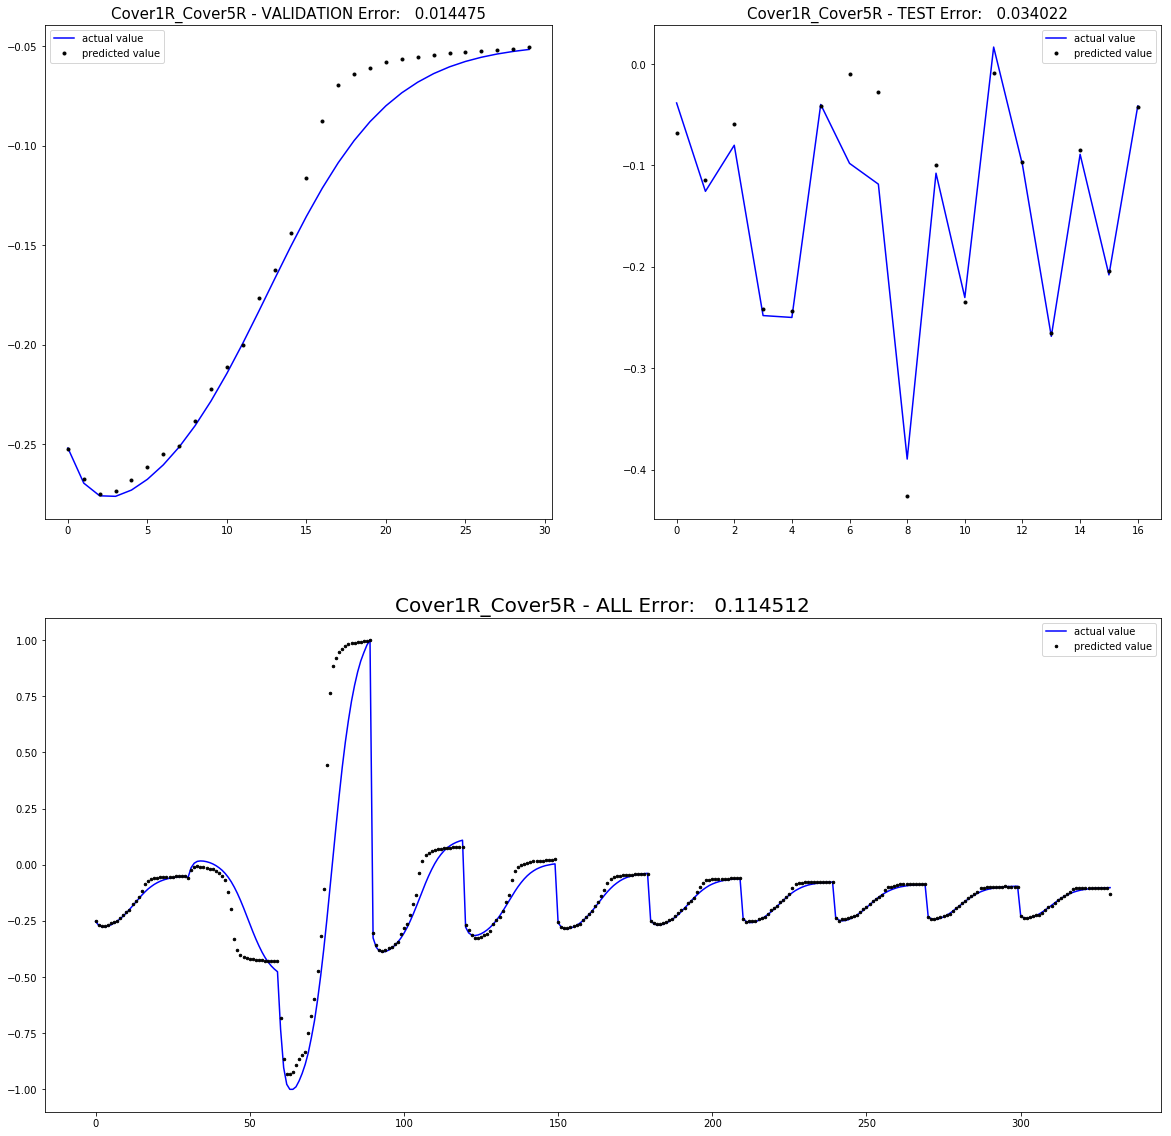

 85%|███████████████████████████████████████████████████████████████████            | 28/33 [2:31:57<27:08, 325.62s/it]


 ******************************************************************************** 
 Processing output Cover2R_Cover3R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'ten', 'units10': 50.85571266465133, 'batch_size': 32, 'units8': 30.63459623337833, 'learning_rate': 0.0034874855181109585, 'units4': 35.81981773554588, 'dropout': 0.0704880294198172, 'units1': 29.82919798079162, 'units2': 62.480782609624455, 'units6': 41.57525991335399, 'units3': 29.423791478585265}
Error: 15.160383061246547 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'ten', 'units10': 31.750177927805275, 'batch_size': 64, 'units8': 33.83283495733331, 'learning_rate': 0.00405964219030804, 'units4': 54.486277587460016, 'dropout': 0.0181798879934852, 'units1': 23.557804944089714, 'units2': 37.374727202921136, 'units6': 56.83774032053998, 'units3': 19.024549267709588}
Error: 2.6862021506407254 

Parameter optimization evalation round: 3
Params testing:  {'num_layers'

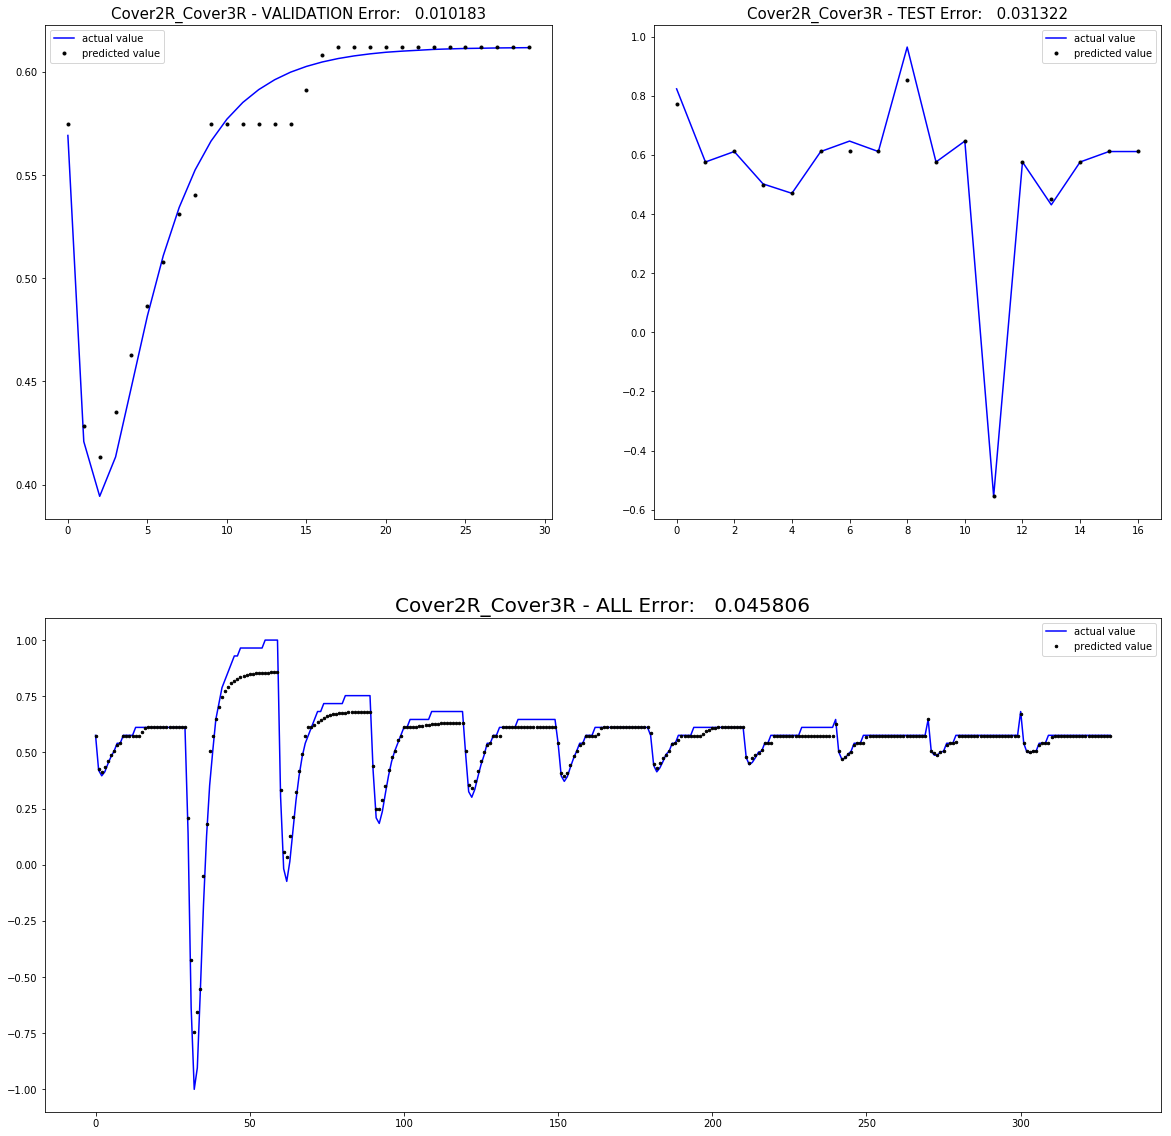

 88%|█████████████████████████████████████████████████████████████████████▍         | 29/33 [2:42:39<22:26, 336.52s/it]


 ******************************************************************************** 
 Processing output Cover2R_Cover5R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'four', 'units10': 31.8369040744688, 'batch_size': 64, 'units8': 54.42854546232678, 'learning_rate': 0.005720720357080623, 'units4': 51.040329086693326, 'dropout': 0.003944239171533648, 'units1': 60.1791318927602, 'units2': 59.87243316880081, 'units6': 21.02447298382362, 'units3': 42.70164631525409}
Error: 2.886989527426876 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'ten', 'units10': 38.79098600370822, 'batch_size': 32, 'units8': 53.96121974811957, 'learning_rate': 0.006665295384836467, 'units4': 62.851642182110055, 'dropout': 0.05633880349332875, 'units1': 40.07251341803457, 'units2': 30.09258650805969, 'units6': 16.152583937686707, 'units3': 47.24141374431863}
Error: 6.145913886126713 

Parameter optimization evalation round: 3
Params testing:  {'num_layers': 's

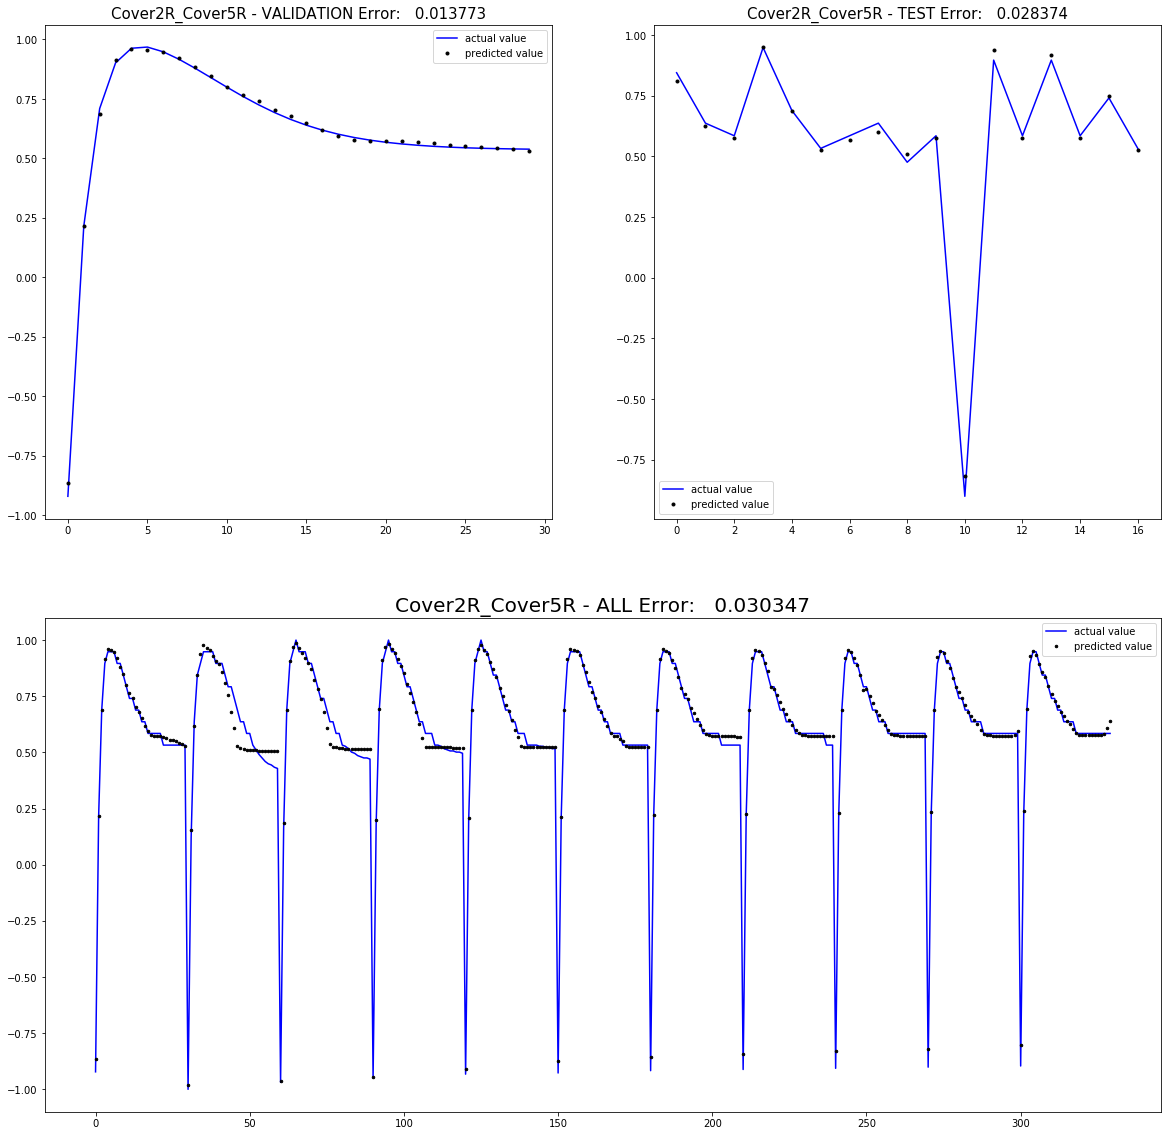

 91%|███████████████████████████████████████████████████████████████████████▊       | 30/33 [2:52:35<17:15, 345.17s/it]


 ******************************************************************************** 
 Processing output Cover3R_Cover4R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'ten', 'units10': 38.47048867077494, 'batch_size': 32, 'units8': 50.52961010843069, 'learning_rate': 0.009458630389530483, 'units4': 24.53025623082458, 'dropout': 0.07219582459224043, 'units1': 27.752711033698084, 'units2': 47.7085858976402, 'units6': 54.315278030739265, 'units3': 21.824084725810785}
Error: 19.48157686761464 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'four', 'units10': 58.2227881337642, 'batch_size': 32, 'units8': 38.10258046952653, 'learning_rate': 0.001796269085889036, 'units4': 29.84018729586395, 'dropout': 0.04547496551188504, 'units1': 27.801561054741008, 'units2': 21.420624057190015, 'units6': 50.84363417990001, 'units3': 54.95949291498014}
Error: 1.9641405568342005 

Parameter optimization evalation round: 3
Params testing:  {'num_layers': 

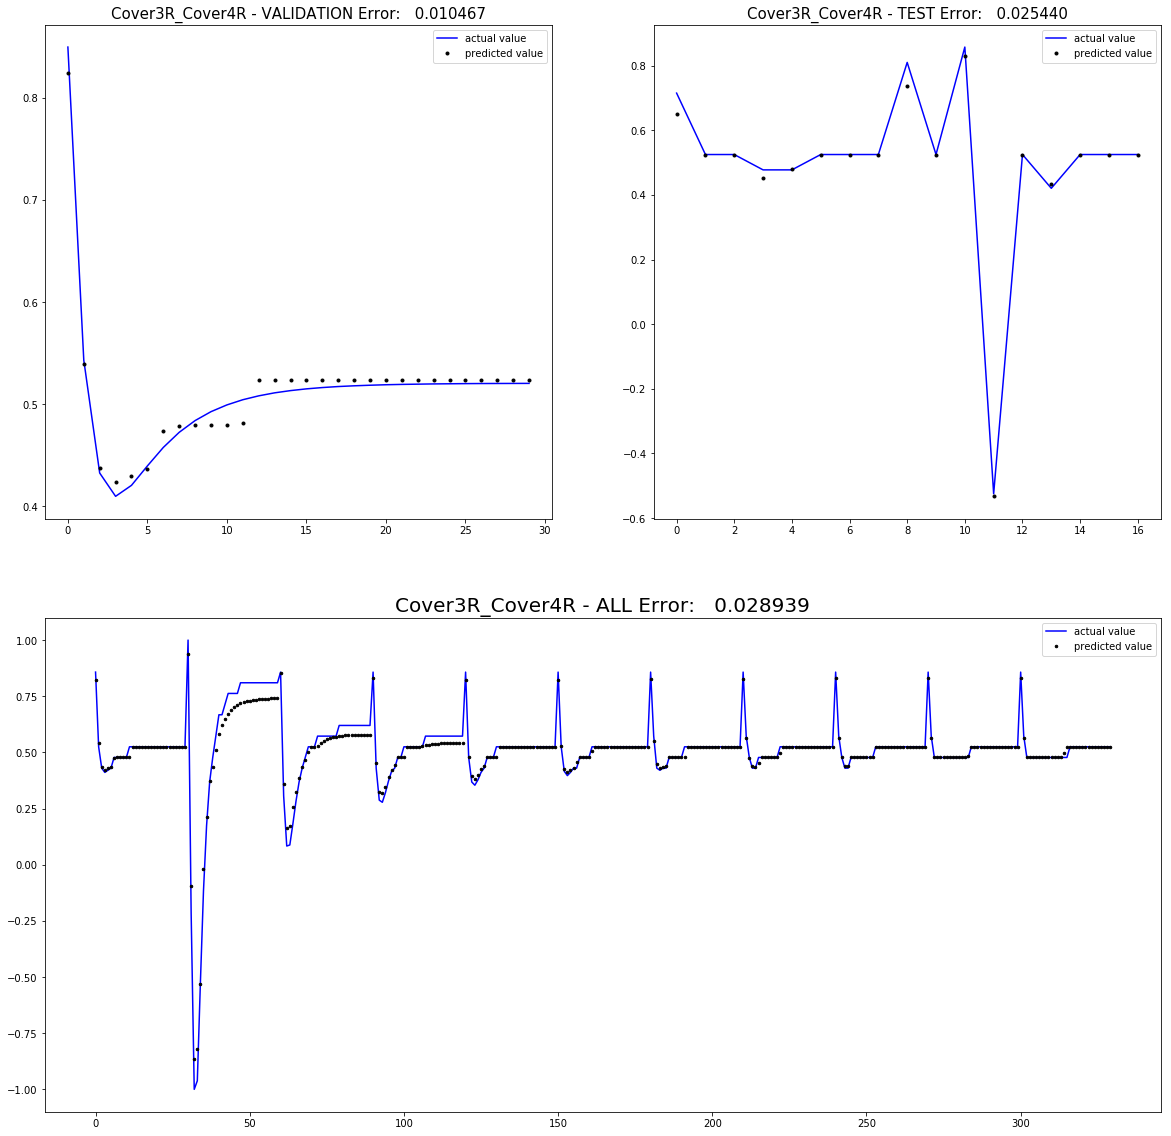

 94%|██████████████████████████████████████████████████████████████████████████▏    | 31/33 [3:04:05<11:52, 356.31s/it]


 ******************************************************************************** 
 Processing output Cover3R_Cover5R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'eight', 'units10': 58.76967337239506, 'batch_size': 32, 'units8': 44.99534416527347, 'learning_rate': 0.0019701576455703265, 'units4': 61.22946382348736, 'dropout': 0.09648396057413584, 'units1': 56.09038108797352, 'units2': 23.715833905509665, 'units6': 35.95919912359788, 'units3': 37.22358481898676}
Error: 37.93121416519777 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'six', 'units10': 60.38884945657635, 'batch_size': 32, 'units8': 61.02905752171045, 'learning_rate': 0.006473100318824416, 'units4': 17.678106046379753, 'dropout': 0.09761567926867101, 'units1': 25.611559026125914, 'units2': 56.11458118843129, 'units6': 24.970334985028003, 'units3': 54.05548706497911}
Error: 93.48861671609752 

Parameter optimization evalation round: 3
Params testing:  {'num_layers'

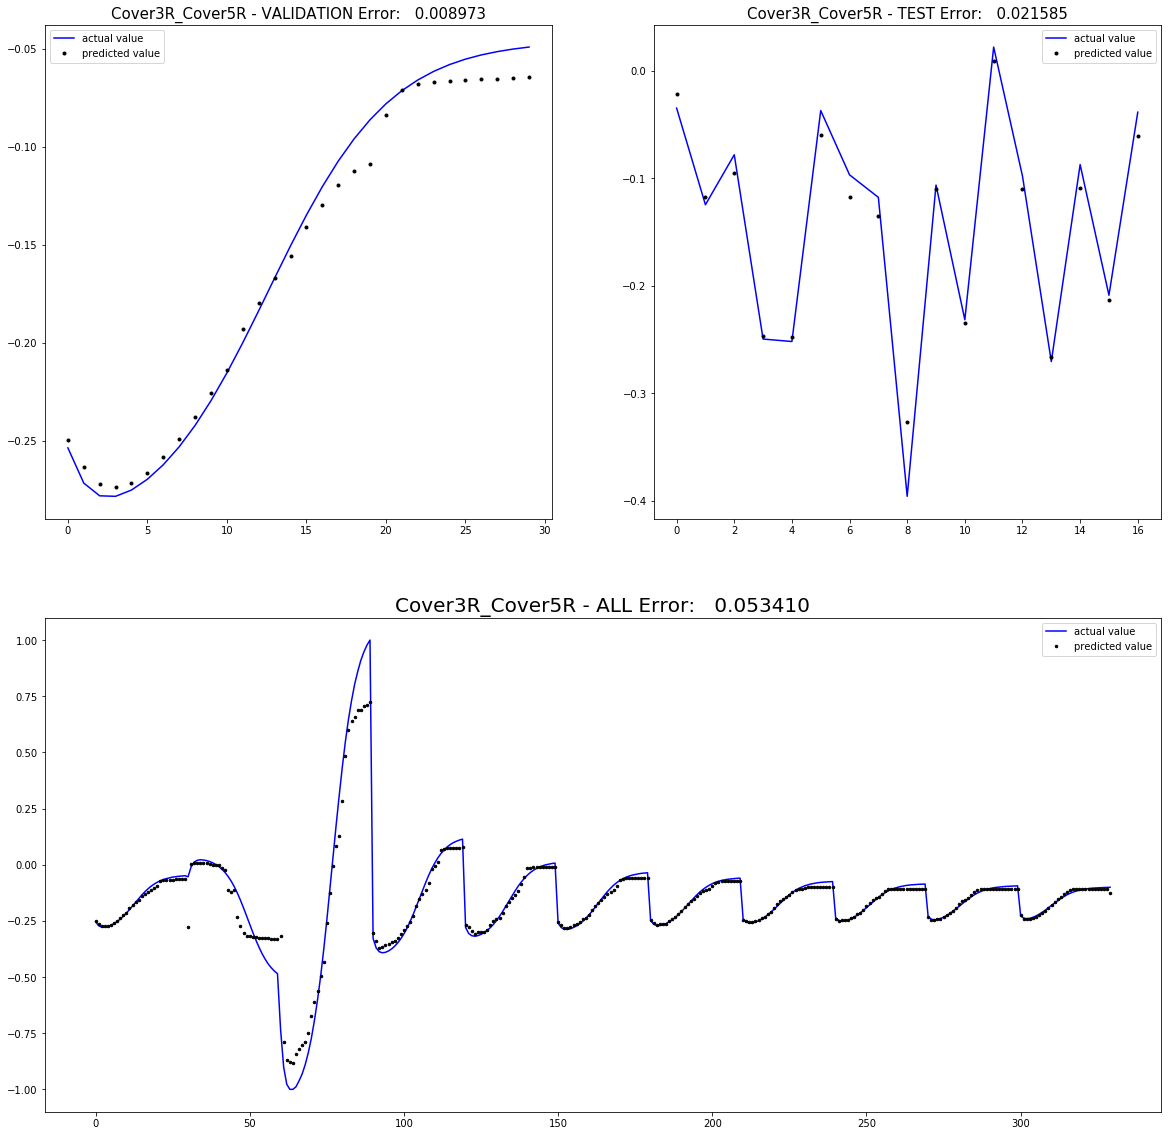

 97%|████████████████████████████████████████████████████████████████████████████▌  | 32/33 [3:27:08<06:28, 388.40s/it]


 ******************************************************************************** 
 Processing output Cover4R_Cover5R
Parameter optimization evalation round: 1
Params testing:  {'num_layers': 'four', 'units10': 45.74336252755158, 'batch_size': 64, 'units8': 61.179343668470665, 'learning_rate': 0.0010039607068164924, 'units4': 28.622916980161953, 'dropout': 0.06794705474480721, 'units1': 19.86003385305561, 'units2': 45.15078815062982, 'units6': 30.786615254230416, 'units3': 58.78760437854204}
Error: 4.846030768607446 

Parameter optimization evalation round: 2
Params testing:  {'num_layers': 'six', 'units10': 35.20857050242618, 'batch_size': 64, 'units8': 53.56047490635893, 'learning_rate': 0.0017518806336530358, 'units4': 39.85275512070794, 'dropout': 0.0396834585336658, 'units1': 62.29990963846249, 'units2': 27.095098139736592, 'units6': 44.05824623582128, 'units3': 54.810737530588774}
Error: 3.35509387173075 

Parameter optimization evalation round: 3
Params testing:  {'num_layers':

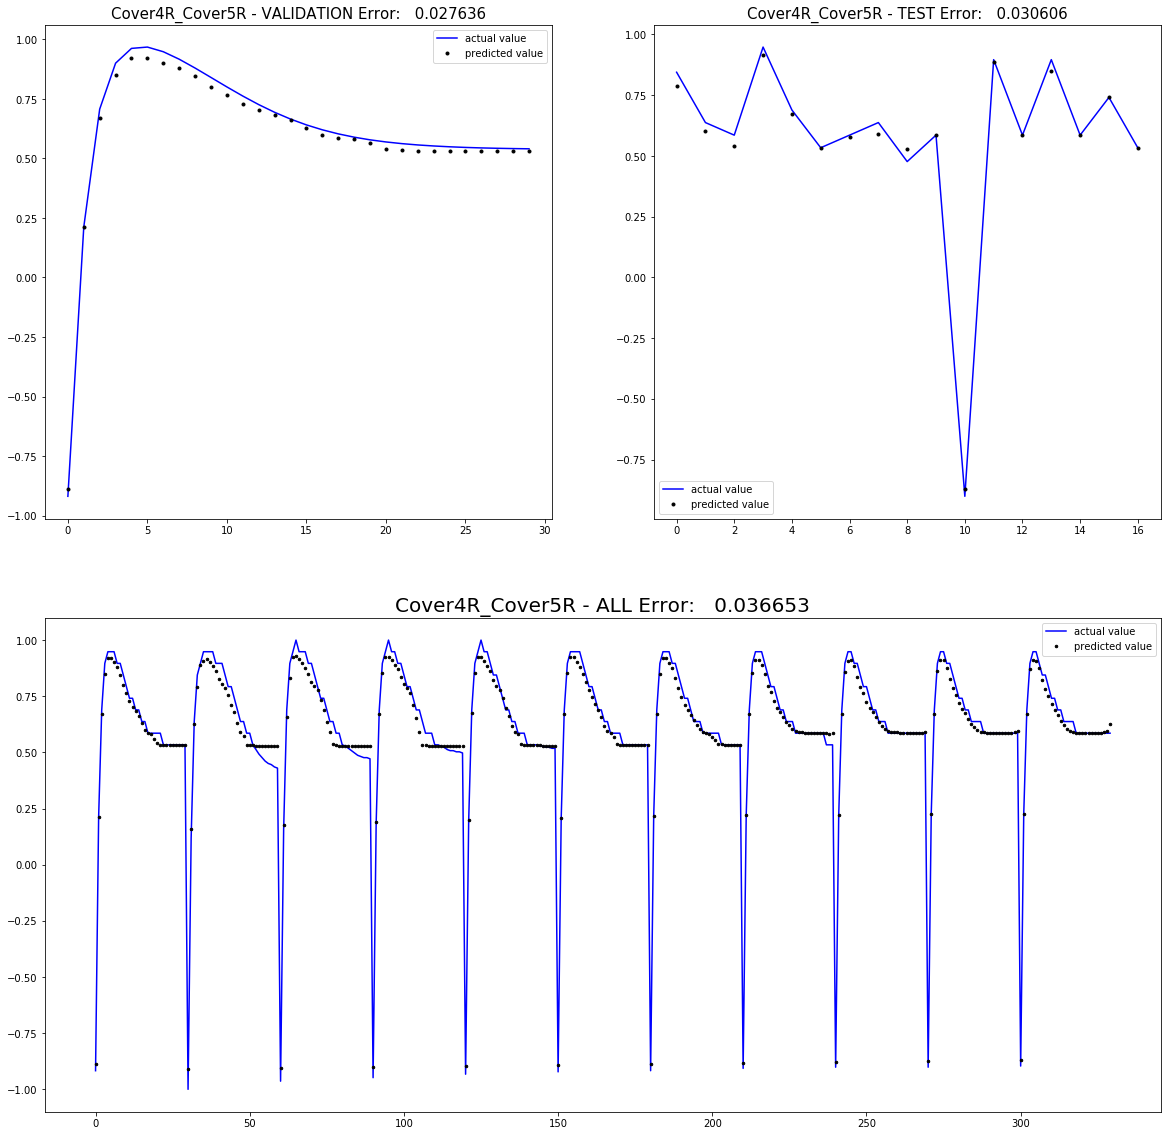

100%|███████████████████████████████████████████████████████████████████████████████| 33/33 [3:42:41<00:00, 404.89s/it]


Total training time:  13361.486354589462 sec


In [15]:
debug = True
nb_epochs = 2000
max_evals = np.full(len(output_list), 5)
#max_evals[[4,5,8,17,23]] = 2 #these are almost constant conductances, no need to optimize

space = {
         'num_layers': hp.choice('num_layers', ['four', 'six', 'eight', 'ten']),

         'units1': hp.uniform('units1', 16, 64),
         'units2': hp.uniform('units2', 16, 64),
         'units3': hp.uniform('units3', 16, 64),
         'units4': hp.uniform('units4', 16, 64),
         'units6': hp.uniform('units6', 16, 64),
         'units8': hp.uniform('units8', 16, 64),
         'units10': hp.uniform('units10', 16, 64),
            
         'dropout': hp.uniform('dropout', 0.0, 0.1),

         'batch_size' : hp.choice('batch_size', [32, 64]),
    
         'learning_rate': hp.uniform('learning_rate', 0.001, 0.01),
        }
start_time = time.time()

for output_col in tqdm(range(len(output_list))):
    
    print("\n","*"*80,"\n","Processing output", output_list[output_col])
    
    y_train = y_train_all[:,output_col]
    y_train = np.resize(y_train,(len(y_train), 1))

    y_test = y_test_all[:,output_col]
    y_test = np.resize(y_test,(len(y_test), 1))
    
    least_error = 1.0e20
    eval_count = 0
    
    #Optimizing using Tree of Parzen Estimators (TPE)
    trials = Trials()
    best_params = fmin(create_model, space, algo=tpe.suggest, max_evals=max_evals[output_col], trials=trials)
    print ('best run: ', best_params)
    
    # load json and create model
    json_file = open(mainPath+"model"+y_data.keys()[output_col]+".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    
    # load weights into new model
    model.load_weights(mainPath+"model"+y_data.keys()[output_col]+".h5")
    print("Loaded model from disk")
    
    if debug:
        #Writing model summary to file
        with open(mainPath+'modelSummary_'+output_list[output_col]+'.txt','w') as fh:
            model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
        #Comparing the actual and predicted values
        fig,ax=plt.subplots(figsize=(20,20))

        #Testing on test data
        predicted1 = model.predict(x_test)
        MSE=mean_squared_error(y_test,predicted1)
        ax1 = plt.subplot(222)
        ax1.plot(y_test,color='blue', label='actual value')
        ax1.plot(predicted1,"k.",markersize=6, label='predicted value')
        ax1.set_title(output_list[output_col] + " - TEST Error: " +"{:10.6f}".format(MSE**0.5),fontsize=15)
        plt.legend()

        #Testing on validation data
        predicted2 = model.predict(x_validation)
        MSE=mean_squared_error(y_validation_all[:,output_col],predicted2)
        ax2 = plt.subplot(221)
        ax2.plot(y_validation_all[:,output_col],color='blue', label='actual value')
        ax2.plot(predicted2,"k.",markersize=6, label='predicted value')
        ax2.set_title(output_list[output_col] + " - VALIDATION Error: " +"{:10.6f}".format(MSE**0.5),fontsize=15)
        plt.legend()

        #Testing on all data
        predicted3 = model.predict(x_temp)
        MSE=mean_squared_error(y_temp[:,output_col],predicted3)
        ax3 = plt.subplot(212)
        ax3.plot(y_temp[:,output_col],color='blue', label='actual value')
        ax3.plot(predicted3,"k.",markersize=5, label='predicted value')
        ax3.set_title(output_list[output_col] + " - ALL Error: " +"{:10.6f}".format(MSE**0.5),fontsize=20)
        plt.legend()

        plt.show()
        fig.savefig(mainPath+output_list[output_col]+".png")

end_time=time.time()
print("Total training time: ", end_time-start_time, "sec")
    